In [1]:

# Parameters
t_min = -40
t_max = 125
bands = ["u", "g", "r", "i", "z", "Y"]
upper_mag = 18
lower_mag = 23
n_obs_min = 20
window_size = 3
y_lower_bound = 2000
y_upper_bound = 11000
GP_K = 6200
W_L_range = 3000
W_U_range = 11000




In [20]:
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'white'
import os, glob
import numpy as np
from tqdm.auto import tqdm
from astropy.table import Table, vstack
from astropy.time import Time, TimeDelta
from astropy import units as u
import pandas as pd
import pickle
from matplotlib.cm import get_cmap
import papermill as pm
import os
import json
import george
from george import kernels
from scipy.optimize import minimize
from matplotlib.lines import Line2D
from tqdm import tqdm
from scipy.stats import iqr


In [3]:
def read_elasticc_file(filename):
    if '_PHOT' in filename:
        headname = filename.replace('_PHOT', '_HEAD')
    else:
        headname = filename
        filename = filename.replace('_HEAD', '_PHOT')
        
    table = Table.read(filename)
    head = Table.read(headname)

    # Sanitize the data
    for _ in table:
        _['BAND'] = _['BAND'].strip()

    head['SNID'] = np.int64(head['SNID'])
    
    # Sanity check 
    if np.sum(table['MJD']<0) != len(head):
        print(filename, 'is broken:', np.sum(table['MJD']<0), '!=', len(head))
        
    # Measured mag and magerr - simulated one is in SIM_MAGOBS
    table['mag'] = np.nan
    table['magerr'] = np.nan
    idx = table['FLUXCAL'] > 0
    
    table['mag'][idx] = 27.5 - 2.5*np.log10(table['FLUXCAL'][idx])
    table['magerr'][idx] = 2.5/np.log(10)*table['FLUXCALERR'][idx]/table['FLUXCAL'][idx]
    
    # Augment table with SNID (light curve id) from head
    table['SNID'] = 0
    
    idx = np.where(table['MJD'] < 0)[0]
    idx = np.hstack((np.array([0]), idx))

    for i in range(1, len(idx)):
        i0,i1 = idx[i - 1], idx[i]
        table['SNID'][i0:i1] = head['SNID'][i - 1]
    
    table = table[table['MJD']>0]

    return table, head

In [4]:

# Effective wavelengths for LSST filters, we will use them as a positions for data points along wavelength direction
lsst_bands = {
    "u": 3670.69,
    "g": 4826.85,
    "r": 6223.24,
    "i": 7545.98,
    "z": 8590.90,
    "Y": 9710.28
}

In [5]:
def compute_gp(sub, shead):
    # We will map the data points onto 2d space - time in days vs wavelength in Angstroms
    t = sub['MJD'] - shead['PEAKMJD'] # Time since true peak
    flux, fluxerr = sub['FLUXCAL'], sub['FLUXCALERR'] # Flux 
    band = np.array([lsst_bands.get(_) for _ in sub['BAND']]) # Effective wavelengths
    x = np.vstack([t, band]).T # 2d positions of data points

    
    # Filter out any rows with NaNs or infinities in the input data
    mask = np.isfinite(flux) & np.isfinite(fluxerr)
    flux, fluxerr = flux[mask], fluxerr[mask]
    
    # Initialize kernel with Matern32 with 100 days and 6000 Angstroms scales
    kernel = 10*np.var(flux)*kernels.Matern32Kernel([linspace, GP_K**2], ndim=2)

    # Set up GP and compute
    gp = george.GP(kernel)
    gp.compute(x, fluxerr)

    # Initial parameters - some amplitude and logarithms of scale parameters
    par0 = gp.get_parameter_vector()
   # print(par0)
    #print("Initial ln-likelihood: {0:.2f}".format(gp.log_likelihood(flux)))

    def neg_ln_like(p):
        gp.set_parameter_vector(p)
        return -gp.log_likelihood(flux)

    def grad_neg_ln_like(p):
        gp.set_parameter_vector(p)
        return -gp.grad_log_likelihood(flux)

    # Bounds for the parameters - we are fixing the last one which is wavelength scale
    bounds = [(0, 10.0*par0[0]), 
              (0, np.log(6000 ** 2)), 
              (None, None)]

    result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like, bounds=bounds)
    #print(result)

    gp.set_parameter_vector(result.x)
    #print("\nMax ln-likelihood: {0:.2f}".format(gp.log_likelihood(flux)))

    # Return variables for this SNID
    return gp, flux, x


In [6]:
linspace = abs(t_min) + t_max
x1 = np.linspace(t_min-20, t_max+20, linspace) # Points along time axis
x2 = np.linspace(y_lower_bound, y_upper_bound, linspace) # Points along wavelength axis

xx1,xx2 = np.meshgrid(x1, x2) 
xx = np.vstack([xx1.flatten(), xx2.flatten()]).T # Points on a 2d grid built from two vectors above

In [7]:
def get_snid_head_sub(table, head):
    snids = np.unique(table['SNID'])
    shead_list = [head[head['SNID'] == snid] for snid in snids]
    sub_list = [table[table['SNID'] == snid] for snid in snids]
    return snids, shead_list, sub_list


In [8]:
def calc_color(x1, gp, flux, band1, band2):
    x_band1 = np.vstack([x1, lsst_bands[band1]*np.ones_like(x1)]).T
    x_band2 = np.vstack([x1, lsst_bands[band2]*np.ones_like(x1)]).T

    flux_band1, fluxerr_band1 = gp.predict(flux, x_band1, return_var=True)
    flux_band2, fluxerr_band2 = gp.predict(flux, x_band2, return_var=True)

    color = -2.5 * np.log10(flux_band1 / flux_band2)
    color_err = np.sqrt((2.5 / np.log(10))**2 * (fluxerr_band1**2 / flux_band1**2 + fluxerr_band2**2 / flux_band2**2))

    return x1, color, color_err


In [46]:
def calc_mean_colors_and_slope(sub, shead, band1, band2):
    t_peak = shead['PEAKMJD']
    g_indices = sub['BAND'] == band1
    
    g_mjd_pre_peak = sub['MJD'][g_indices & (sub['MJD'] <= t_peak)] - t_peak

    gp, flux, x = compute_gp(sub, shead)

    x_pre_peak, color_pre_peak, _ = calc_color(g_mjd_pre_peak, gp, flux, band1, band2)
    mean_color_pre_peak = np.mean(color_pre_peak)

    g_mjd_post_peak = sub['MJD'][g_indices & (sub['MJD'] > t_peak)] - t_peak

    x_post_peak, color_post_peak, _ = calc_color(g_mjd_post_peak, gp, flux, band1, band2)
    mean_color_post_peak = np.mean(color_post_peak)

    t = g_mjd_post_peak
    color = color_post_peak

    slope, _, _, _ = np.linalg.lstsq(t[:, np.newaxis], color, rcond=None)
   
    if store_plot_data:
        return mean_color_pre_peak, mean_color_post_peak, slope[0], (t, color)
   
    return mean_color_pre_peak, mean_color_post_peak, slope[0]


In [109]:
def calc_mean_colors_and_slope(sub, shead, band1, band2):
    t_peak = shead['PEAKMJD']
    g_indices = sub['BAND'] == band1
    g_mjd_pre_peak = sub['MJD'][g_indices & (sub['MJD'] <= t_peak)] - t_peak

    gp, flux, x = compute_gp(sub, shead)

    x_pre_peak, color_pre_peak, _ = calc_color(g_mjd_pre_peak, gp, flux, band1, band2)
    mean_color_pre_peak = np.mean(color_pre_peak)

    g_mjd_post_peak = sub['MJD'][g_indices & (sub['MJD'] > t_peak) & (sub['MJD'] <= t_peak + 100)] - t_peak
    
    x_post_peak, color_post_peak, _ = calc_color(g_mjd_post_peak, gp, flux, band1, band2)
    mean_color_post_peak = np.mean(color_post_peak)

    t = g_mjd_post_peak
    color = color_post_peak
    
    if len(t) == 0:
        #print("Debug: Skipping due to empty t.")
        return None, None, None, None
    
    if len(t) < 2:
        #print("Debug: Skipping due to insufficient data points.")
        return None, None, None, None

    if np.isnan(t).any() or np.isnan(color).any():
        #print("Debug: Skipping due to NaN values.")
        return None, None, None, None

    if np.isinf(t).any() or np.isinf(color).any():
       # print("Debug: Skipping due to Inf values.")
        return None, None, None, None

    if len(set(t)) == 1:
        #print("Debug: Skipping due to lack of variation in x-values.")
        return None, None, None, None
     
    # Get the best-fit line and its covariance matrix
    p, cov = np.polyfit(t, color, 1, cov=True)
    slope_std_err = np.sqrt(cov[0, 0])

    return mean_color_pre_peak, mean_color_post_peak, p[0], slope_std_err


  0%|                                                                                                                                                                                    | 0/3 [00:00<?, ?it/s]/home/kunal/tdes-fzu/venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kunal/tdes-fzu/venv/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Skipping SNID 231322 due to error: the number of data points must exceed order to scale the covariance matrix
Skipping SNID 277715 due to error: the number of data points must exceed order to scale the covariance matrix
Skipping SNID 489155 due to error: the number of data points must exceed order to scale the covariance matrix
Skipping SNID 587331 due to error: the number of data points must exceed order to scale the covariance matrix


/tmp/ipykernel_200833/1690719555.py:8: RuntimeWarning: invalid value encountered in log10
  color = -2.5 * np.log10(flux_band1 / flux_band2)


Skipping SNID 1541172 due to error: the number of data points must exceed order to scale the covariance matrix
Skipping SNID 1770549 due to error: the number of data points must exceed order to scale the covariance matrix
Skipping SNID 1890340 due to error: the number of data points must exceed order to scale the covariance matrix
Skipping SNID 2003900 due to error: the number of data points must exceed order to scale the covariance matrix
Skipping SNID 2250898 due to error: the number of data points must exceed order to scale the covariance matrix
Skipping SNID 2315749 due to error: the number of data points must exceed order to scale the covariance matrix
Skipping SNID 2391438 due to error: the number of data points must exceed order to scale the covariance matrix
Skipping SNID 2588135 due to error: the number of data points must exceed order to scale the covariance matrix
Skipping SNID 2606182 due to error: the number of data points must exceed order to scale the covariance matrix
S

 33%|████████████████████████████████████████████████████████                                                                                                                | 1/3 [37:56<1:15:53, 2276.95s/it]

AGN: 775 processed


/home/kunal/tdes-fzu/venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kunal/tdes-fzu/venv/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_200833/1690719555.py:8: RuntimeWarning: invalid value encountered in log10
  color = -2.5 * np.log10(flux_band1 / flux_band2)


Skipping SNID 195316 due to error: the number of data points must exceed order to scale the covariance matrix
Skipping SNID 491498 due to error: the number of data points must exceed order to scale the covariance matrix
Skipping SNID 608780 due to error: the number of data points must exceed order to scale the covariance matrix
Skipping SNID 690476 due to error: the number of data points must exceed order to scale the covariance matrix
Skipping SNID 909850 due to error: the number of data points must exceed order to scale the covariance matrix
Skipping SNID 1318887 due to error: the number of data points must exceed order to scale the covariance matrix
Skipping SNID 1549540 due to error: the number of data points must exceed order to scale the covariance matrix
Skipping SNID 1615736 due to error: the number of data points must exceed order to scale the covariance matrix
Skipping SNID 1744739 due to error: the number of data points must exceed order to scale the covariance matrix
Skippi

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 2/3 [1:00:16<28:45, 1725.39s/it]

Skipping SNID 73990309 due to error: the number of data points must exceed order to scale the covariance matrix
Skipping SNID 73991369 due to error: the number of data points must exceed order to scale the covariance matrix
TDE: 1228 processed


/home/kunal/tdes-fzu/venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kunal/tdes-fzu/venv/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_200833/1690719555.py:8: RuntimeWarning: invalid value encountered in log10
  color = -2.5 * np.log10(flux_band1 / flux_band2)


Skipping SNID 174565 due to error: the number of data points must exceed order to scale the covariance matrix
Skipping SNID 334789 due to error: the number of data points must exceed order to scale the covariance matrix
Skipping SNID 455670 due to error: the number of data points must exceed order to scale the covariance matrix
Skipping SNID 589631 due to error: the number of data points must exceed order to scale the covariance matrix
Skipping SNID 647499 due to error: the number of data points must exceed order to scale the covariance matrix
Skipping SNID 688443 due to error: the number of data points must exceed order to scale the covariance matrix
Skipping SNID 763061 due to error: the number of data points must exceed order to scale the covariance matrix
Skipping SNID 767865 due to error: the number of data points must exceed order to scale the covariance matrix
Skipping SNID 814214 due to error: the number of data points must exceed order to scale the covariance matrix
Skipping S

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [1:32:34<00:00, 1851.50s/it]

SNE: 1345 processed


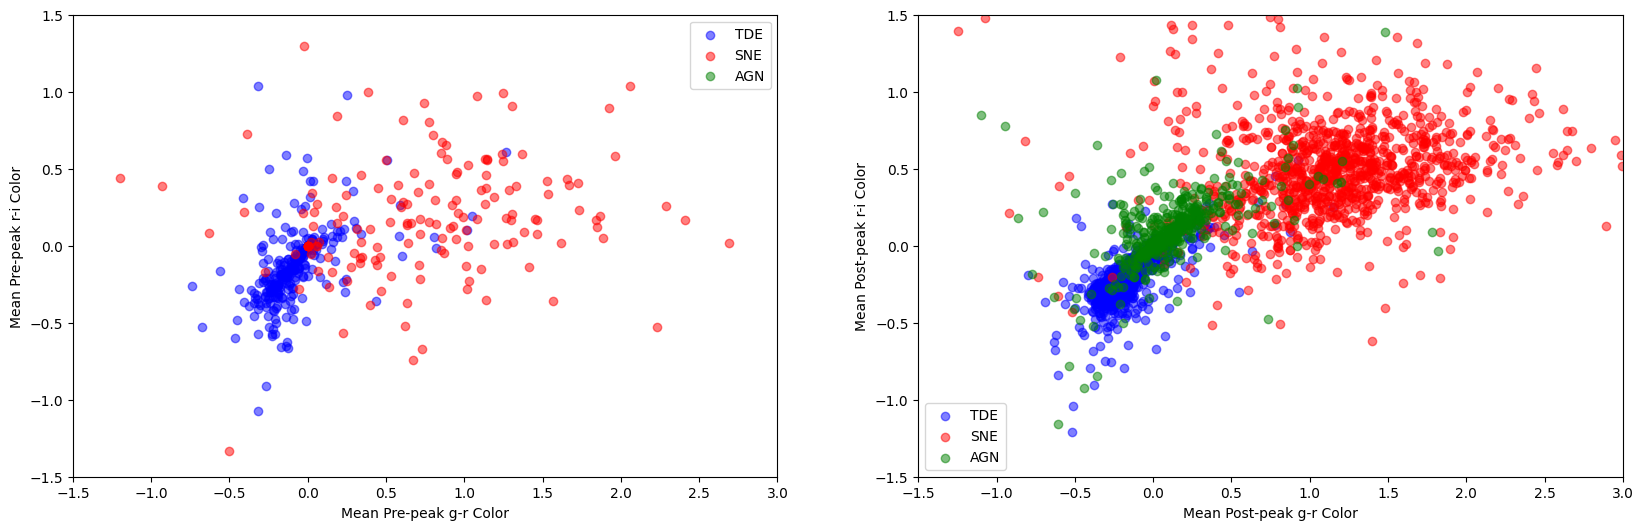

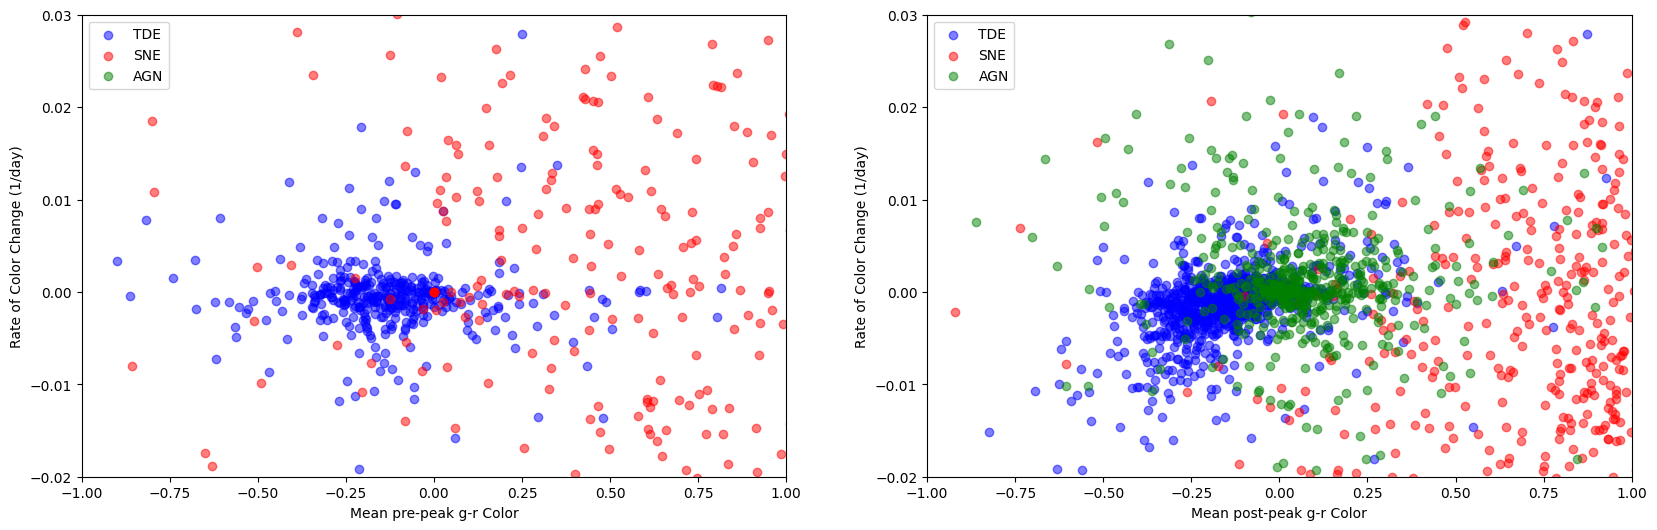

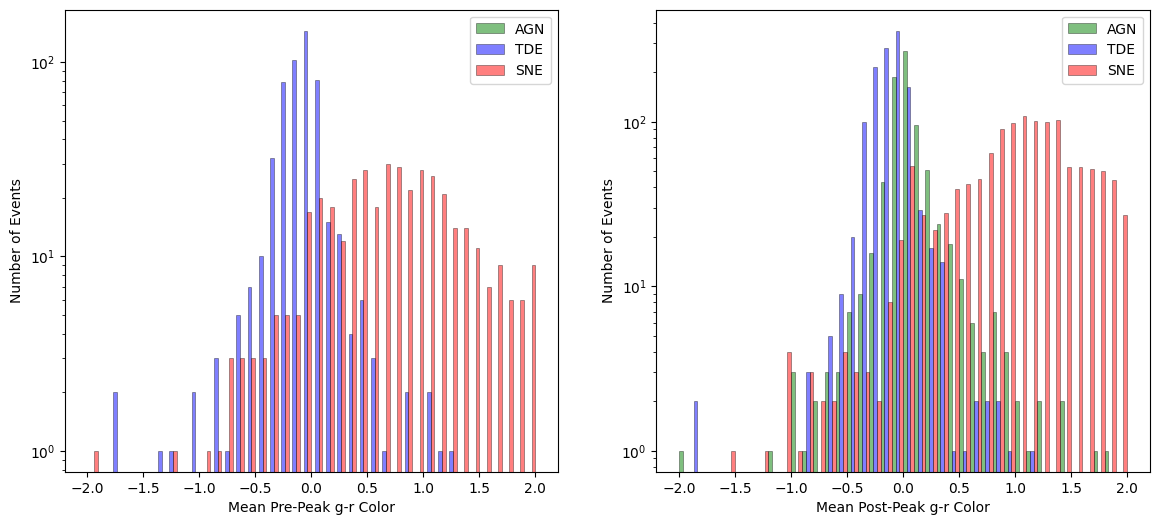

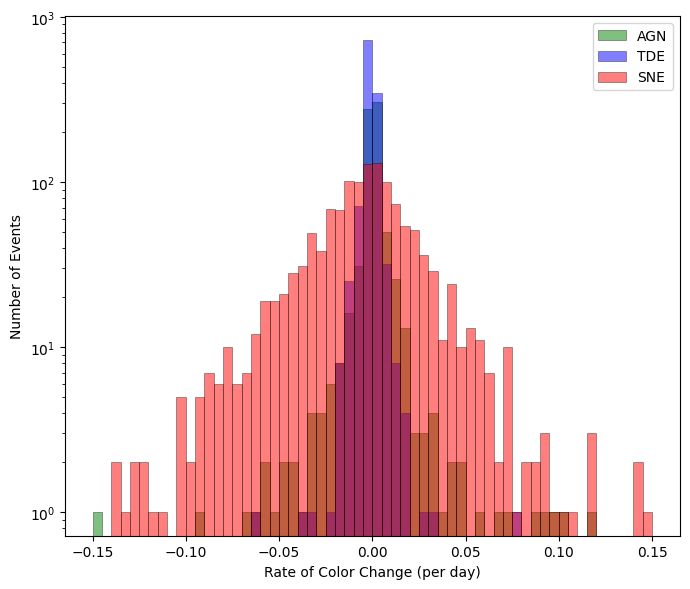

Elapsed time: 5561.233786344528 seconds


In [110]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
# Imports and setup
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import time

start_time = time.time()

# Constructing file paths
agn_filenames = [f"/home/kunal/elasticc/fits/ELASTICC_TRAIN_AGN/ELASTICC_TRAIN_NONIaMODEL0-{str(i).zfill(4)}_HEAD.FITS.gz" for i in range(1, 2)]
tde_filenames = [f"/home/kunal/elasticc/fits/ELASTICC_TRAIN_TDE/ELASTICC_TRAIN_NONIaMODEL0-{str(i).zfill(4)}_HEAD.FITS.gz" for i in range(1, 2)]
sne_filenames = [f"/home/kunal/elasticc/fits/ELASTICC_TRAIN_SNIa-SALT2/ELASTICC_TRAIN_NONIaMODEL0-{str(i).zfill(4)}_HEAD.FITS.gz" for i in range(1, 2)]

# Merging lists
all_filenames = agn_filenames + tde_filenames + sne_filenames
object_types = ['AGN'] * len(agn_filenames) + ['TDE'] * len(tde_filenames) + ['SNE'] * len(sne_filenames)

# Initialize lists to hold calculated values
all_mean_colors_pre_peak = []
all_mean_colors_post_peak = []
all_mean_colors_pre_peak_ri = []
all_mean_colors_post_peak_ri = []
all_color_slopes = []
all_object_types = []
all_color_slope_std_errs = []

# Main loop to calculate mean colors and slopes
for filename, object_type in tqdm(zip(all_filenames, object_types), total=len(all_filenames)):
    table, head = read_elasticc_file(filename)  # Assuming this function is defined elsewhere
    snids, shead_list, sub_list = get_snid_head_sub(table, head)  # Assuming this function is defined elsewhere

    # Initialize lists to hold calculated values for each file
    mean_colors_pre_peak = []
    mean_colors_post_peak = []
    color_slopes = []
    color_slope_std_errs = []
    mean_colors_pre_peak_ri = []
    mean_colors_post_peak_ri = []

    # Inner loop for each supernova ID
    for snid, shead, sub in zip(snids, shead_list, sub_list):
        try:
            # Calculate mean colors and slope (g-r)
            mean_color_pre_peak, mean_color_post_peak, color_slope, slope_std_err = calc_mean_colors_and_slope(sub, shead, 'g', 'r')
            
            # Calculate mean colors (r-i)
            mean_color_pre_peak_ri, mean_color_post_peak_ri, _, _ = calc_mean_colors_and_slope(sub, shead, 'r', 'i')

            # Append to lists if none of the values are None
            if all(val is not None for val in [mean_color_pre_peak, mean_color_post_peak, color_slope]):
                mean_colors_pre_peak.append(mean_color_pre_peak)
                mean_colors_post_peak.append(mean_color_post_peak)
                color_slopes.append(color_slope)
                color_slope_std_errs.append(slope_std_err)
                mean_colors_pre_peak_ri.append(mean_color_pre_peak_ri)
                mean_colors_post_peak_ri.append(mean_color_post_peak_ri)
        except ValueError as e:
            print(f"Skipping SNID {snid} due to error: {e}")

    # Extend global lists with values calculated from this file
    all_mean_colors_pre_peak.extend(mean_colors_pre_peak)
    all_mean_colors_post_peak.extend(mean_colors_post_peak)
    all_color_slopes.extend(color_slopes)
    all_color_slope_std_errs.extend(color_slope_std_errs)
    all_mean_colors_pre_peak_ri.extend(mean_colors_pre_peak_ri)
    all_mean_colors_post_peak_ri.extend(mean_colors_post_peak_ri)
    all_object_types.extend([object_type] * len(mean_colors_pre_peak))

    total_items = len(snids)
    processed_items = len(mean_colors_pre_peak)
    ratio = processed_items / total_items if total_items != 0 else 0
    percentage = ratio * 100
    print(f"{object_type}: {processed_items} processed out of {total_items} total (Ratio: {ratio}, Percentage: {percentage}%)")
    
    
#color-color diagrams
fig4, (ax6, ax7) = plt.subplots(1, 2, figsize=(20, 6))

colors = {'TDE': 'blue', 'SNE': 'red', 'AGN': 'green'}

# Loop to plot different types of objects with different colors
for object_type in ['TDE', 'SNE', 'AGN']:
    mask = np.array(all_object_types) == object_type

    # pre-peak g-r vs r-i
    ax6.scatter(np.array(all_mean_colors_pre_peak)[mask], np.array(all_mean_colors_pre_peak_ri)[mask], label=object_type, alpha=0.5, color=colors[object_type])

    # post-peak g-r vs r-i
    ax7.scatter(np.array(all_mean_colors_post_peak)[mask], np.array(all_mean_colors_post_peak_ri)[mask], label=object_type, alpha=0.5, color=colors[object_type])

ax6.set_xlabel("Mean Pre-peak g-r Color")
ax6.set_ylabel("Mean Pre-peak r-i Color")
ax6.set_xlim(-1.5, 3)
ax6.set_ylim(-1.5, 1.5)
ax6.legend()

ax7.set_xlabel("Mean Post-peak g-r Color")
ax7.set_ylabel("Mean Post-peak r-i Color")
ax7.set_xlim(-1.5, 3)
ax7.set_ylim(-1.5, 1.5)
ax7.legend()

plt.show()
 
#Plots of mean g-r vs rate of color change

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
colors = {'TDE': 'blue', 'SNE': 'red', 'AGN': 'green'}

for object_type in ['TDE', 'SNE', 'AGN']:
    mask = np.array(all_object_types) == object_type
    ax1.scatter(np.array(all_mean_colors_pre_peak)[mask], np.array(all_color_slopes)[mask], label=object_type, alpha=0.5, color=colors[object_type])
    ax2.scatter(np.array(all_mean_colors_post_peak)[mask], np.array(all_color_slopes)[mask], label=object_type, alpha=0.5, color=colors[object_type])

ax1.set_xlabel("Mean pre-peak g-r Color")
ax1.set_ylabel("Rate of Color Change (1/day)")
ax1.set_xlim(-1, 1)
ax1.set_ylim(-0.02, 0.03)
ax1.legend()

ax2.set_xlabel("Mean post-peak g-r Color")
ax2.set_ylabel("Rate of Color Change (1/day)")
ax2.set_xlim(-1, 1)
ax2.set_ylim(-0.02, 0.03)
ax2.legend()

plt.show()



# Histograms
fig2, (ax3, ax4) = plt.subplots(1, 2, figsize=(14, 6))

bin_width = 0.1
bin_edges = np.arange(-2, 2 + bin_width, bin_width)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

width = bin_width / 3
for object_type, color, shift in zip(['AGN', 'TDE', 'SNE'], ['green', 'blue', 'red'], [-width, 0, width]):
    mask = np.array(all_object_types) == object_type
    pre_peak_colors = np.array(all_mean_colors_pre_peak)[mask]
    post_peak_colors = np.array(all_mean_colors_post_peak)[mask]

    hist_pre_peak, _ = np.histogram(pre_peak_colors, bins=bin_edges)
    hist_post_peak, _ = np.histogram(post_peak_colors, bins=bin_edges)

    ax3.bar(bin_centers + shift, hist_pre_peak, width=width, color=color, alpha=0.5, label=object_type, edgecolor='k', linewidth=0.5)
    ax4.bar(bin_centers + shift, hist_post_peak, width=width, color=color, alpha=0.5, label=object_type, edgecolor='k', linewidth=0.5)

ax3.set_xlabel("Mean Pre-Peak g-r Color")
ax3.set_ylabel("Number of Events")
ax3.legend()
ax3.set_yscale('log')

ax4.set_xlabel("Mean Post-Peak g-r Color")
ax4.set_ylabel("Number of Events")
ax4.legend()
ax4.set_yscale('log')

fig3, ax5 = plt.subplots(1, 1, figsize=(7, 6))

bin_edges_color_slope = np.arange(-0.15, 0.15 + 0.005, 0.005)

for object_type, color in zip(['AGN', 'TDE', 'SNE'], ['green', 'blue', 'red']):
    mask = np.array(all_object_types) == object_type
    color_slopes = np.array(all_color_slopes)[mask]
    ax5.hist(color_slopes, alpha=0.5, color=color, label=object_type, bins=bin_edges_color_slope, edgecolor='k', linewidth=0.5)

ax5.set_xlabel("Rate of Color Change (per day)")
ax5.set_ylabel("Number of Events")
ax5.set_yscale('log')
ax5.legend()


plt.tight_layout()
plt.show()


end_time = time.time()
print(f"Elapsed time: {end_time - start_time} seconds")



In [49]:
def calc_mean_colors_and_slope(sub, shead, band1, band2, return_plot_data=False):
    t_peak = shead['PEAKMJD']
    g_indices = sub['BAND'] == band1
    
    g_mjd_pre_peak = sub['MJD'][g_indices & (sub['MJD'] <= t_peak)] - t_peak

    gp, flux, x = compute_gp(sub, shead)

    x_pre_peak, color_pre_peak, _ = calc_color(g_mjd_pre_peak, gp, flux, band1, band2)
    mean_color_pre_peak = np.mean(color_pre_peak)

    g_mjd_post_peak = sub['MJD'][g_indices & (sub['MJD'] > t_peak)] - t_peak

    x_post_peak, color_post_peak, _ = calc_color(g_mjd_post_peak, gp, flux, band1, band2)
    mean_color_post_peak = np.mean(color_post_peak)

    t = g_mjd_post_peak
    color = color_post_peak

    slope, _, _, _ = np.linalg.lstsq(t[:, np.newaxis], color, rcond=None)
    
    if return_plot_data:
        return mean_color_pre_peak, mean_color_post_peak, slope[0], (t, color)
    return mean_color_pre_peak, mean_color_post_peak, slope[0]
    



  0%|                                                                                                                                                                                    | 0/2 [00:00<?, ?it/s]/home/kunal/tdes-fzu/venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kunal/tdes-fzu/venv/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


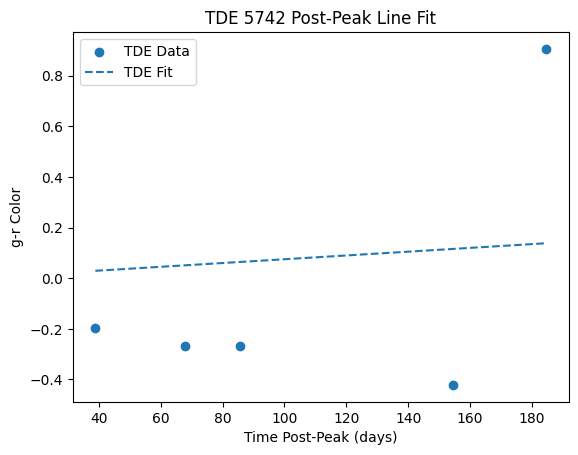

/tmp/ipykernel_200833/1690719555.py:8: RuntimeWarning: invalid value encountered in log10
  color = -2.5 * np.log10(flux_band1 / flux_band2)


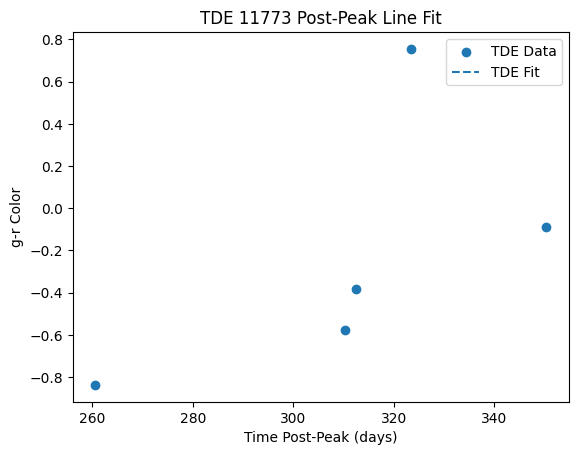

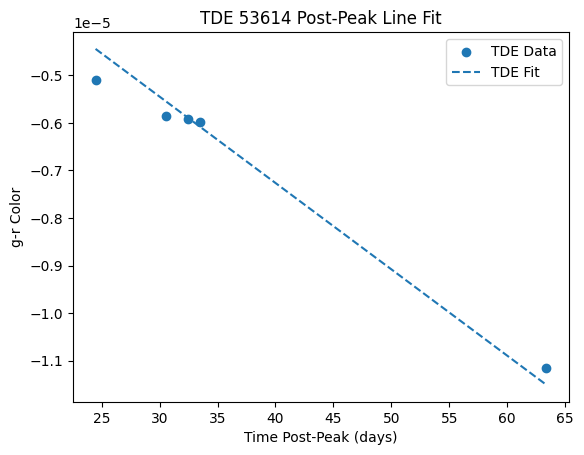

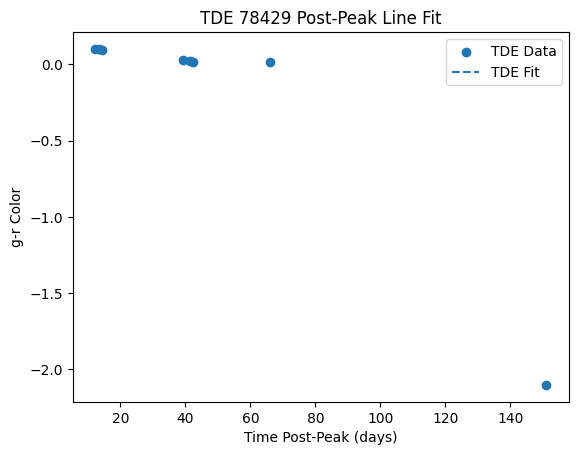

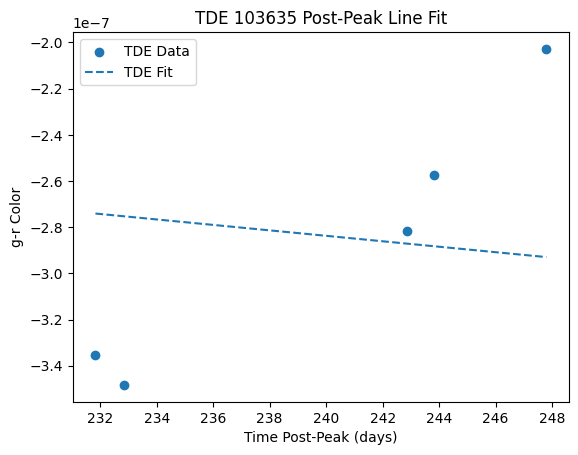

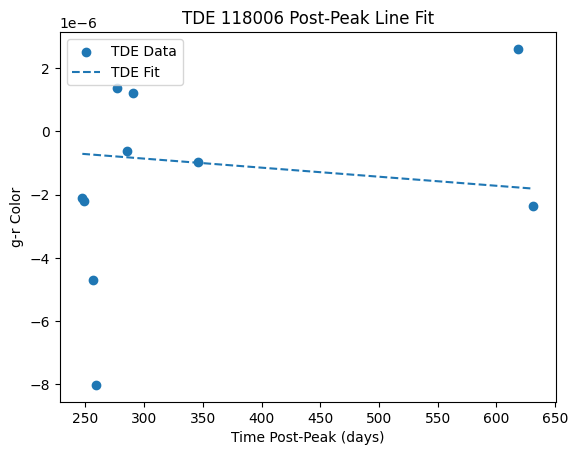

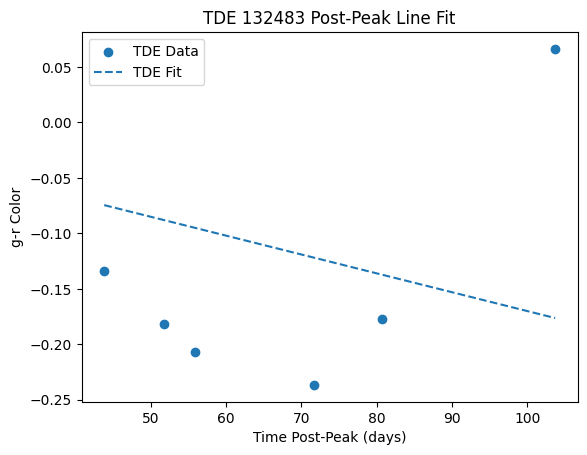

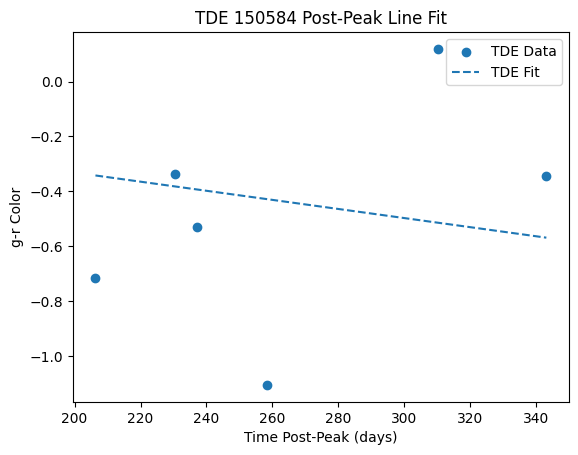

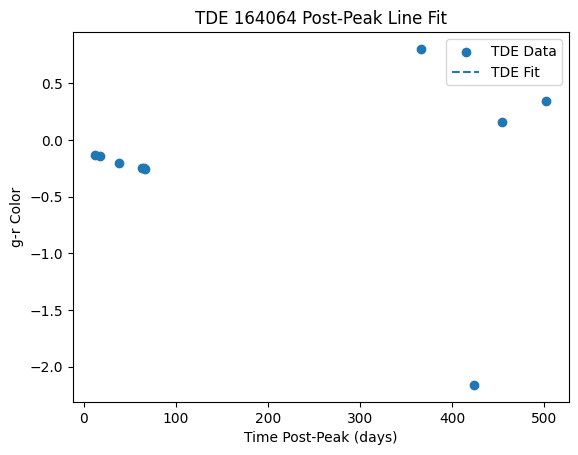

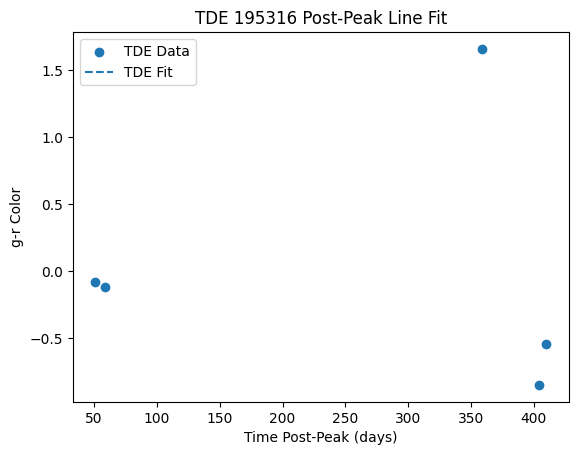

Skipping SNID 66769601 due to error: array must not contain infs or NaNs


 50%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 1/2 [12:27<12:27, 747.94s/it]/home/kunal/tdes-fzu/venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kunal/tdes-fzu/venv/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_200833/1690719555.py:8: RuntimeWarning: invalid value encountered in log10
  color = -2.5 * np.log10(flux_band1 / flux_band2)


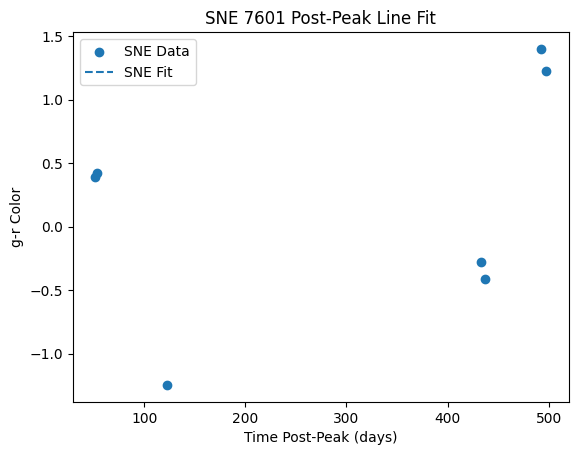

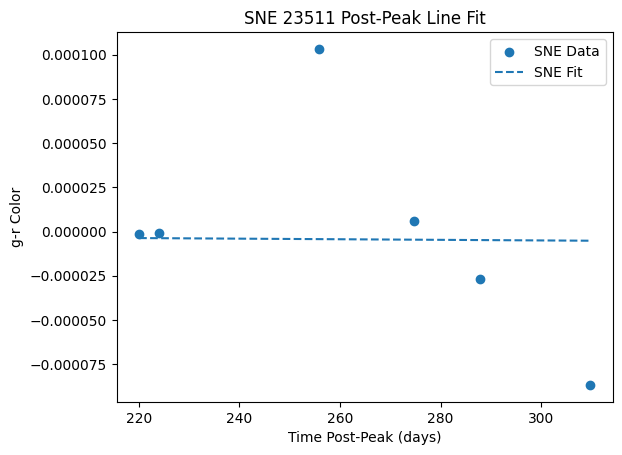

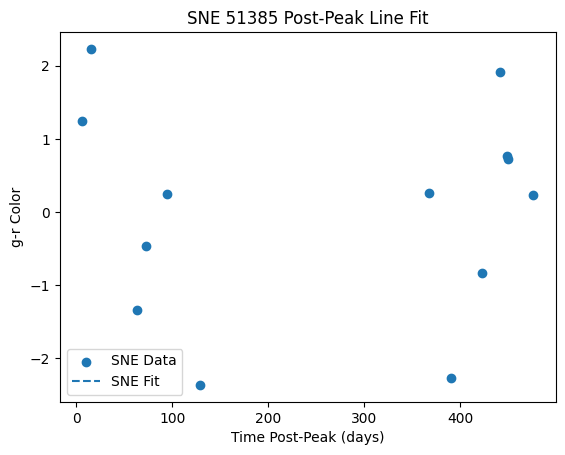

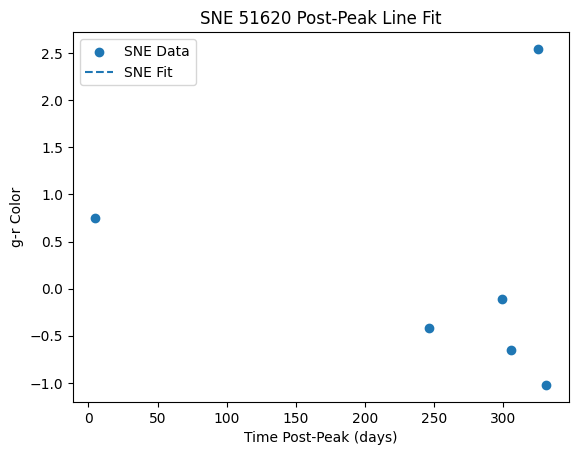

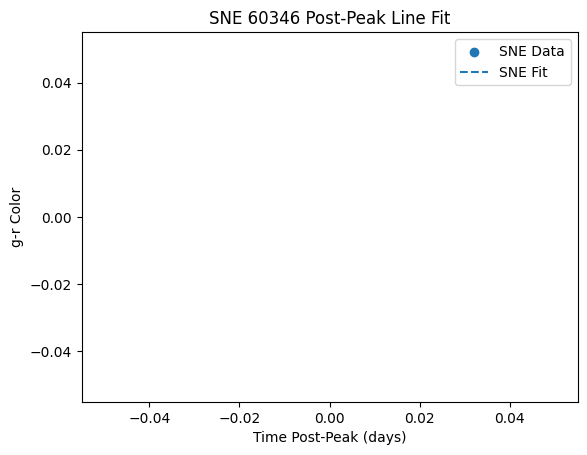

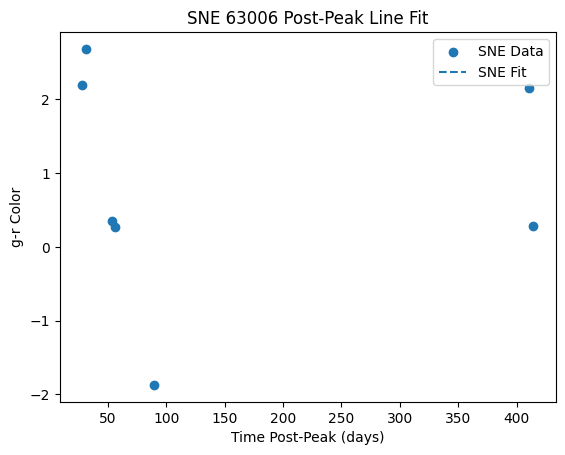

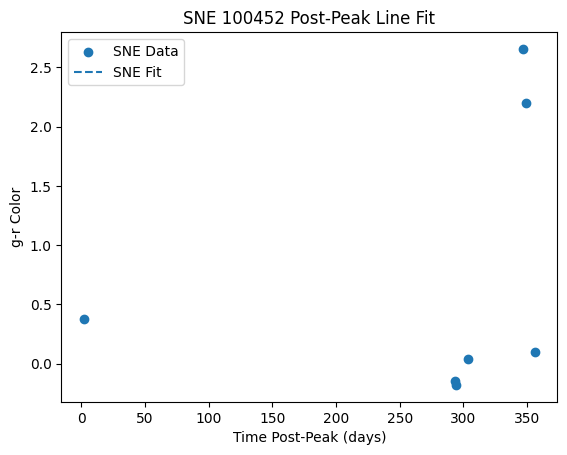

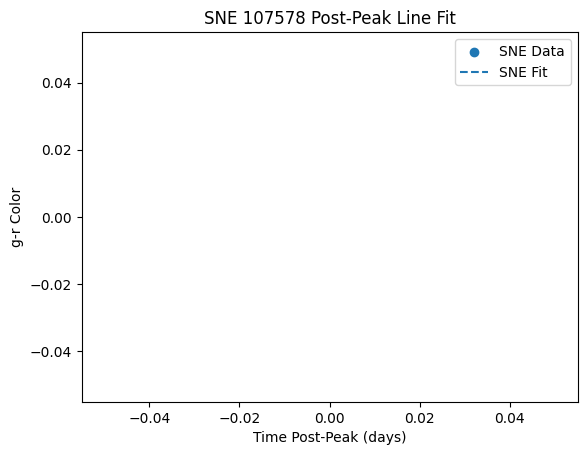

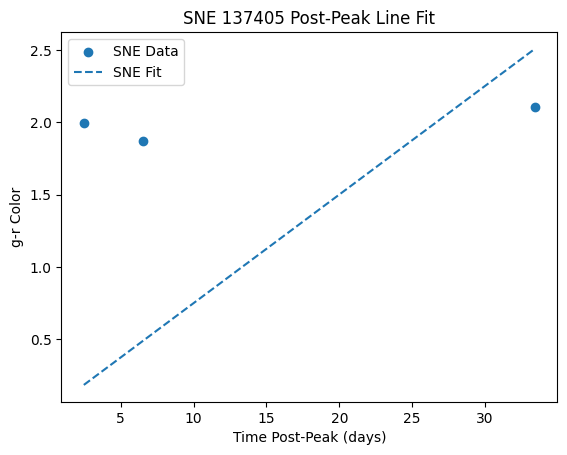

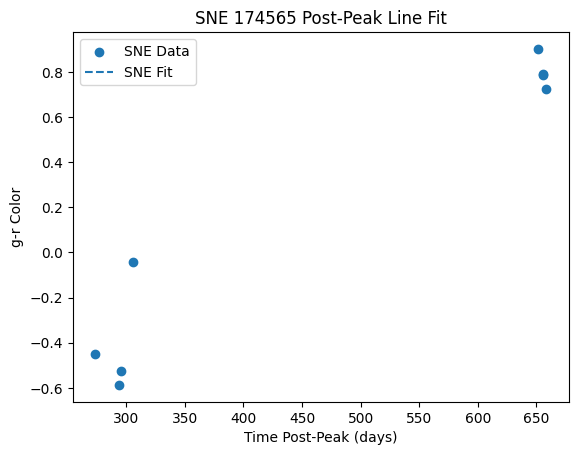

 50%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 1/2 [14:57<14:57, 897.59s/it]


KeyboardInterrupt: 

In [50]:
#To debug gp powered rate of color change 


#agn_filenames = [f"/home/kunal/elasticc/fits/ELASTICC_TRAIN_AGN/ELASTICC_TRAIN_NONIaMODEL0-{str(i).zfill(4)}_HEAD.FITS.gz" for i in range(1, 2)]
tde_filenames = [f"/home/kunal/elasticc/fits/ELASTICC_TRAIN_TDE/ELASTICC_TRAIN_NONIaMODEL0-{str(i).zfill(4)}_HEAD.FITS.gz" for i in range(1, 2)]
sne_filenames = [f"/home/kunal/elasticc/fits/ELASTICC_TRAIN_SNIa-SALT2/ELASTICC_TRAIN_NONIaMODEL0-{str(i).zfill(4)}_HEAD.FITS.gz" for i in range(1, 2)]

all_filenames =  tde_filenames + sne_filenames
object_types = ['TDE'] * len(tde_filenames) + ['SNE'] * len(sne_filenames)


    
all_color_slopes = []
all_object_types = []

# Initialize counters
num_TDEs_plotted = 0
num_SNEs_plotted = 0

# Store plot data
plot_data_TDEs = []
plot_data_SNEs = []

#Call the calc_mean_colors_and_slope function

for filename, object_type in tqdm(zip(all_filenames, object_types), total=len(all_filenames)):
    table, head = read_elasticc_file(filename)
    snids, shead_list, sub_list = get_snid_head_sub(table, head)


    color_slopes = []

    for snid, shead, sub in zip(snids, shead_list, sub_list):
        try:
            return_plot_data = False
            if (object_type == 'TDE' and num_TDEs_plotted < 10) or (object_type == 'SNE' and num_SNEs_plotted < 10):
                return_plot_data = True
            
            if return_plot_data:
                mean_color_pre_peak, mean_color_post_peak, color_slope, plot_data = calc_mean_colors_and_slope(sub, shead, 'g', 'r', True)
                t, color = plot_data
                # Plot the data and fit line for this specific object
                plt.figure()
                plt.scatter(t, color, label=f'{object_type} Data')
                plt.plot(t, color_slope * t, label=f'{object_type} Fit', linestyle='--')
                plt.xlabel('Time Post-Peak (days)')
                plt.ylabel('g-r Color')
                plt.legend()
                plt.title(f'{object_type} {snid} Post-Peak Line Fit')
                plt.show()
                
                if object_type == 'TDE':
                    num_TDEs_plotted += 1
                elif object_type == 'SNE':
                    num_SNEs_plotted += 1
            else:
                mean_color_pre_peak, mean_color_post_peak, color_slope = calc_mean_colors_and_slope(sub, shead, 'g', 'r')

        except ValueError as e:
            print(f"Skipping SNID {snid} due to error: {e}")




In [86]:
def calc_mean_colors_and_slope(sub, shead, band1, band2, return_plot_data=False):
    t_peak = shead['PEAKMJD']
    g_indices = sub['BAND'] == band1
    
    g_mjd_pre_peak = sub['MJD'][g_indices & (sub['MJD'] <= t_peak)] - t_peak

    gp, flux, x = compute_gp(sub, shead)

    x_pre_peak, color_pre_peak, _ = calc_color(g_mjd_pre_peak, gp, flux, band1, band2)
    mean_color_pre_peak = np.mean(color_pre_peak)

    g_mjd_post_peak = sub['MJD'][g_indices & (sub['MJD'] > t_peak) & (sub['MJD'] <= t_peak + 100)] - t_peak

    x_post_peak, color_post_peak, _ = calc_color(g_mjd_post_peak, gp, flux, band1, band2)
    mean_color_post_peak = np.mean(color_post_peak)

    t = g_mjd_post_peak
    color = color_post_peak

    slope, _, _, _ = np.linalg.lstsq(t[:, np.newaxis], color, rcond=None)

    if return_plot_data:
        plot_data = (t, color)
        return mean_color_pre_peak, mean_color_post_peak, slope[0], plot_data

    return mean_color_pre_peak, mean_color_post_peak, slope[0]


  0%|                                                                                                                                                                                    | 0/2 [00:00<?, ?it/s]/home/kunal/tdes-fzu/venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kunal/tdes-fzu/venv/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


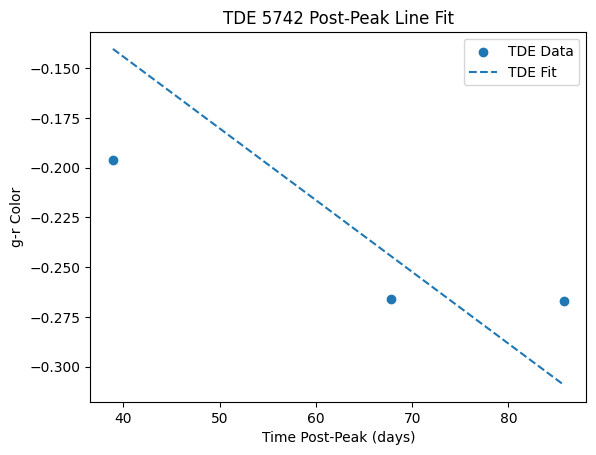

/tmp/ipykernel_200833/1690719555.py:8: RuntimeWarning: invalid value encountered in log10
  color = -2.5 * np.log10(flux_band1 / flux_band2)


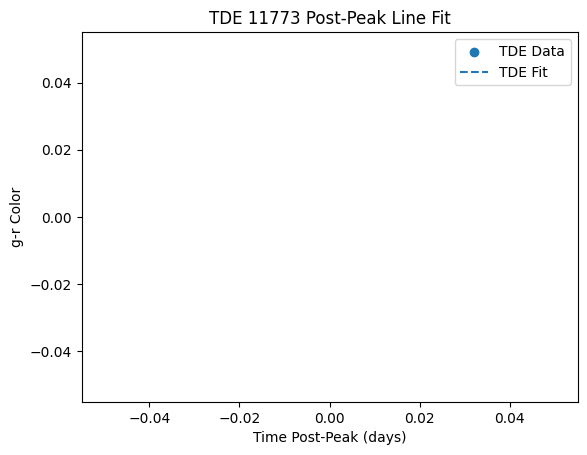

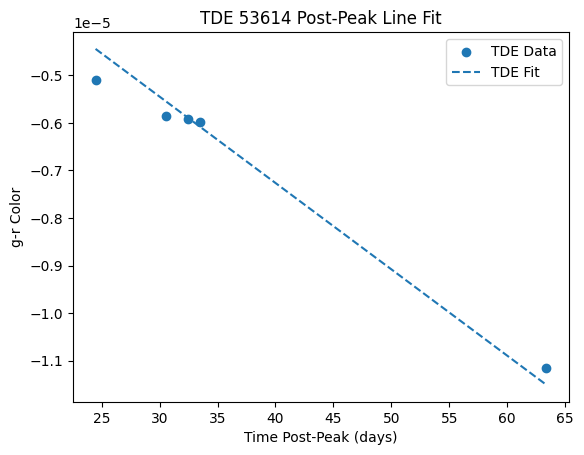

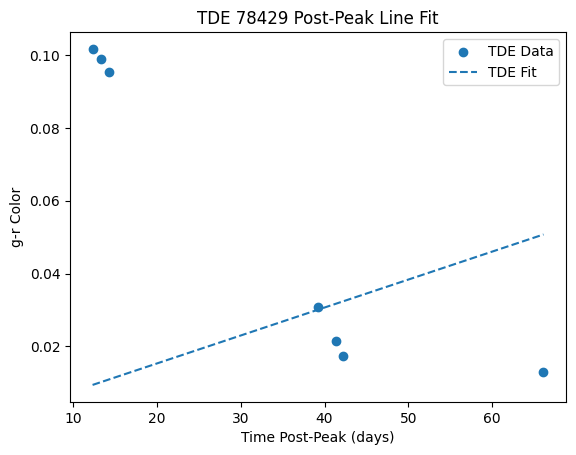

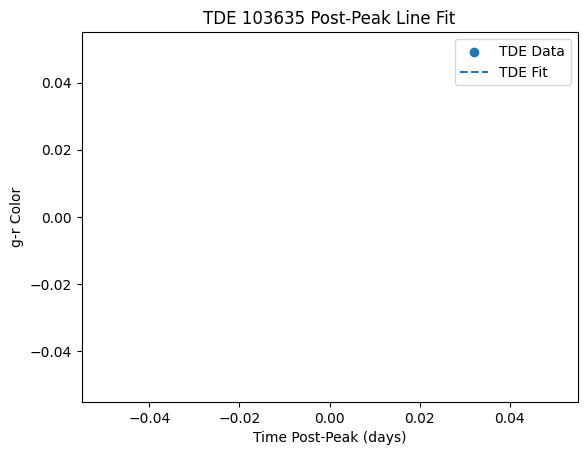

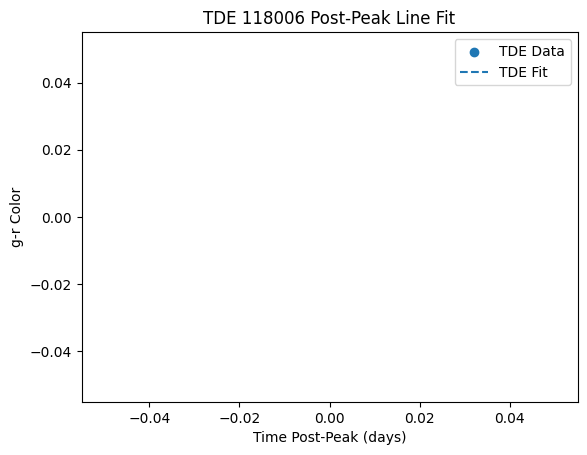

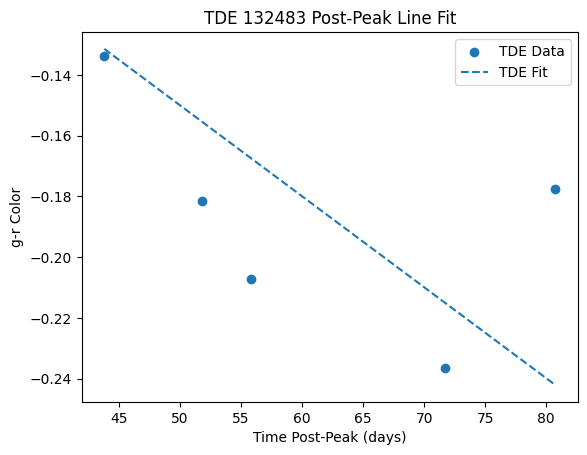

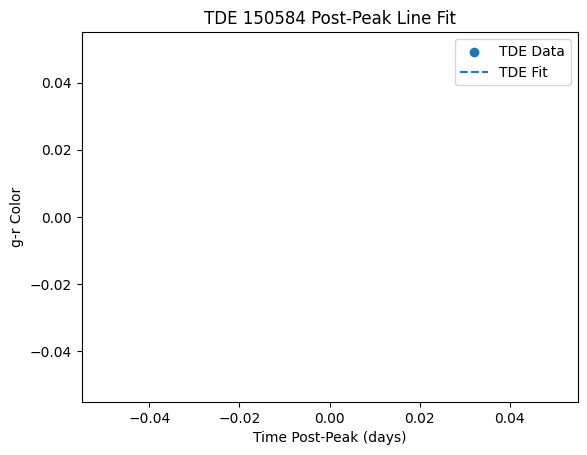

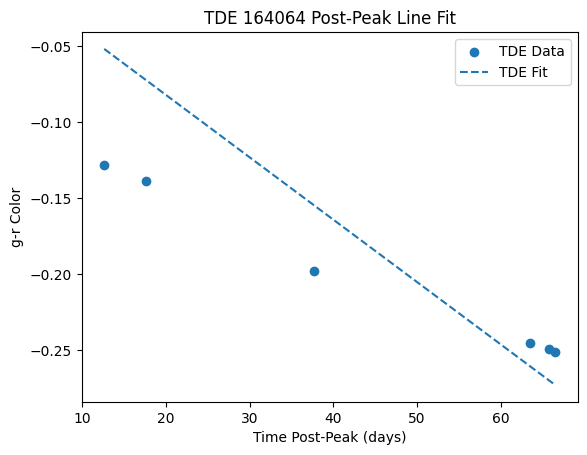

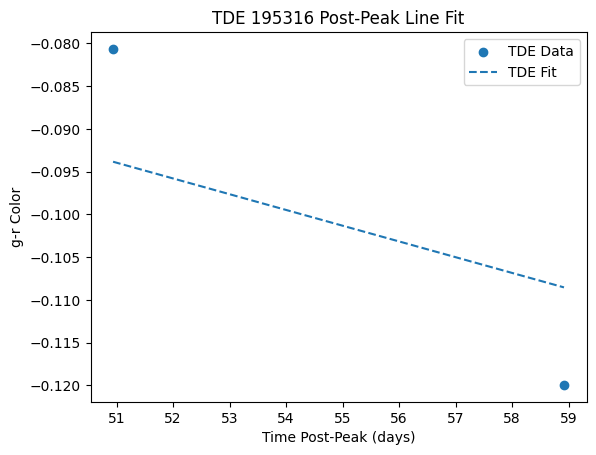

  0%|                                                                                                                                                                                    | 0/2 [02:15<?, ?it/s]


KeyboardInterrupt: 

In [87]:

# Initialize counters
num_TDEs_plotted = 0
num_SNEs_plotted = 0

# Store plot data
plot_data_TDEs = []
plot_data_SNEs = []

for filename, object_type in tqdm(zip(all_filenames, object_types), total=len(all_filenames)):
    table, head = read_elasticc_file(filename)
    snids, shead_list, sub_list = get_snid_head_sub(table, head)

    color_slopes = []

    for snid, shead, sub in zip(snids, shead_list, sub_list):
        try:
            return_plot_data = False
            if (object_type == 'TDE' and num_TDEs_plotted < 10) or (object_type == 'SNE' and num_SNEs_plotted < 10):
                return_plot_data = True

            if return_plot_data:
                mean_color_pre_peak, mean_color_post_peak, color_slope, plot_data = calc_mean_colors_and_slope(sub, shead, 'g', 'r', return_plot_data=True)
                t, color = plot_data
                
                # Plot the data and fit line for this specific object
                plt.figure()
                plt.scatter(t, color, label=f'{object_type} Data')
                plt.plot(t, color_slope * t, label=f'{object_type} Fit', linestyle='--')
                plt.xlabel('Time Post-Peak (days)')
                plt.ylabel('g-r Color')
                plt.legend()
                plt.title(f'{object_type} {snid} Post-Peak Line Fit')
                plt.show()

                if object_type == 'TDE':
                    num_TDEs_plotted += 1
                elif object_type == 'SNE':
                    num_SNEs_plotted += 1
            else:
                mean_color_pre_peak, mean_color_post_peak, color_slope = calc_mean_colors_and_slope(sub, shead, 'g', 'r', return_plot_data=False)

        except ValueError as e:
            print(f"Skipping SNID {snid} due to error: {e}")



In [101]:
def calc_mean_colors_and_slope(sub, shead, band1, band2, return_plot_data=False):
    t_peak = shead['PEAKMJD']
    g_indices = sub['BAND'] == band1
    g_mjd_pre_peak = sub['MJD'][g_indices & (sub['MJD'] <= t_peak)] - t_peak

    gp, flux, x = compute_gp(sub, shead)

    x_pre_peak, color_pre_peak, _ = calc_color(g_mjd_pre_peak, gp, flux, band1, band2)
    mean_color_pre_peak = np.mean(color_pre_peak)

    g_mjd_post_peak = sub['MJD'][g_indices & (sub['MJD'] > t_peak) & (sub['MJD'] <= t_peak + 100)] - t_peak
    
    x_post_peak, color_post_peak, _ = calc_color(g_mjd_post_peak, gp, flux, band1, band2)
    mean_color_post_peak = np.mean(color_post_peak)

    t = g_mjd_post_peak
    color = color_post_peak
    
    if len(t) == 0:
        print("Debug: Skipping due to empty t.")
        return None
    
    if len(t) < 2:
        print("Debug: Skipping due to insufficient data points.")
        return None

    if np.isnan(t).any() or np.isnan(color).any():
        print("Debug: Skipping due to NaN values.")
        return None

    if np.isinf(t).any() or np.isinf(color).any():
        print("Debug: Skipping due to Inf values.")
        return None

    if len(set(t)) == 1:
        print("Debug: Skipping due to lack of variation in x-values.")
        return None
     
    # Get the best-fit line and its covariance matrix
    p, cov = np.polyfit(t, color, 1, cov=True)
    slope_std_err = np.sqrt(cov[0, 0])

    if return_plot_data:
        plot_data = (t, color, slope_std_err)
        return mean_color_pre_peak, mean_color_post_peak, p[0], slope_std_err, plot_data
    else:
        return mean_color_pre_peak, mean_color_post_peak, p[0], slope_std_err


  0%|                                                                                                                                                                                    | 0/2 [00:00<?, ?it/s]/home/kunal/tdes-fzu/venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kunal/tdes-fzu/venv/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


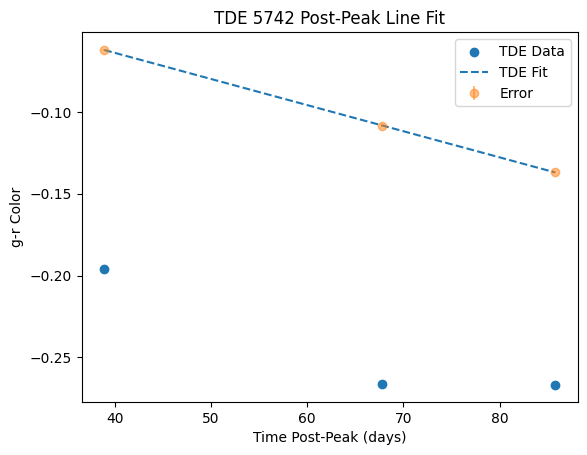

/tmp/ipykernel_200833/1690719555.py:8: RuntimeWarning: invalid value encountered in log10
  color = -2.5 * np.log10(flux_band1 / flux_band2)


Debug: Skipping due to empty t.
Skipping SNID 11773 due to empty data.


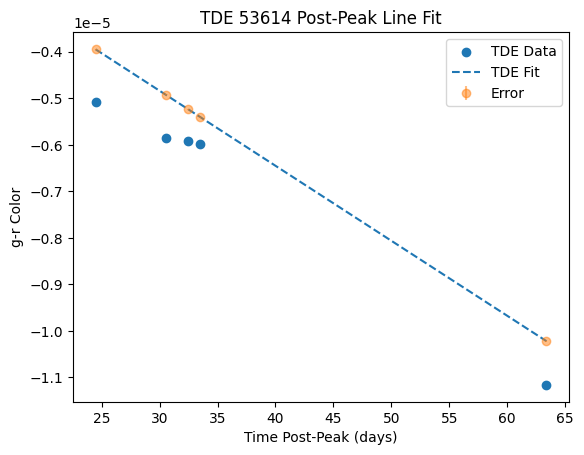

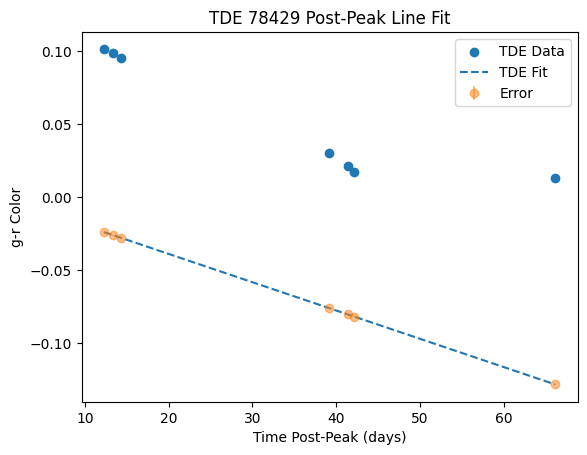

Debug: Skipping due to empty t.
Skipping SNID 103635 due to empty data.
Debug: Skipping due to empty t.
Skipping SNID 118006 due to empty data.


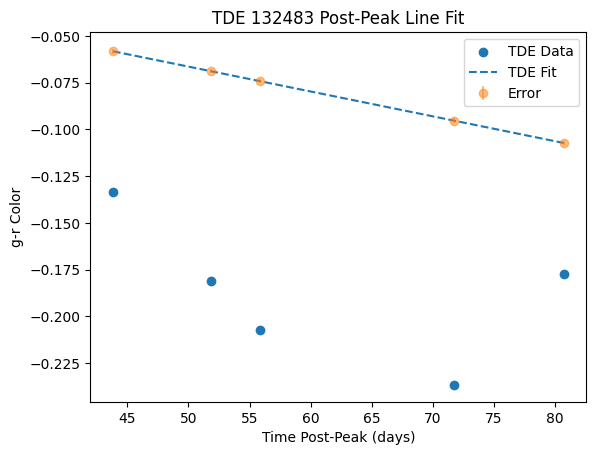

Debug: Skipping due to empty t.
Skipping SNID 150584 due to empty data.


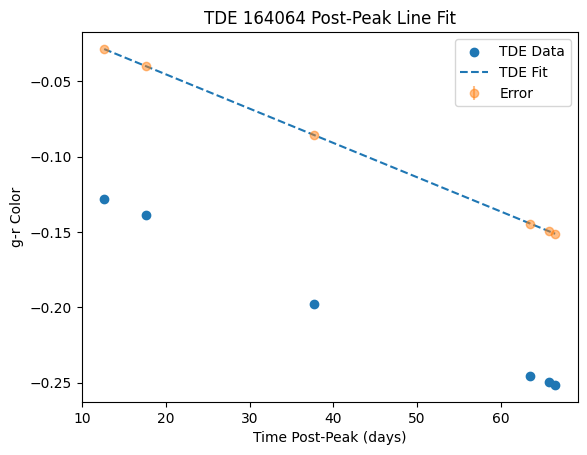

Skipping SNID 195316 due to error: the number of data points must exceed order to scale the covariance matrix


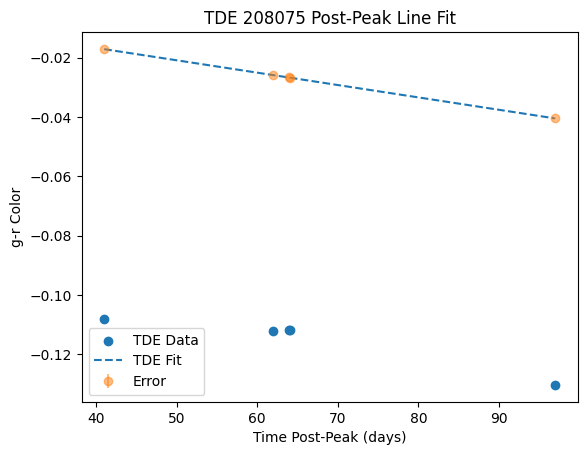

Debug: Skipping due to insufficient data points.
Skipping SNID 316293 due to empty data.


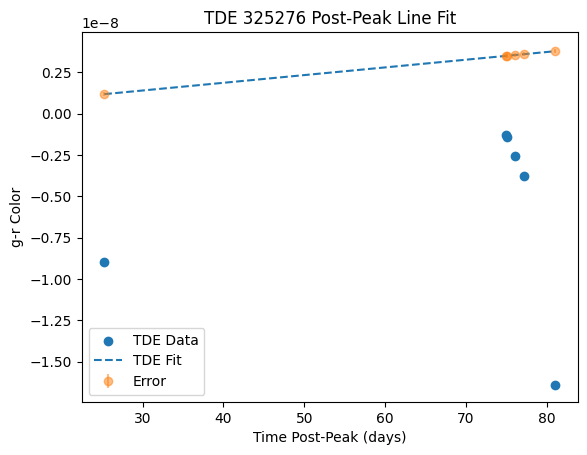

Debug: Skipping due to insufficient data points.
Skipping SNID 385152 due to empty data.


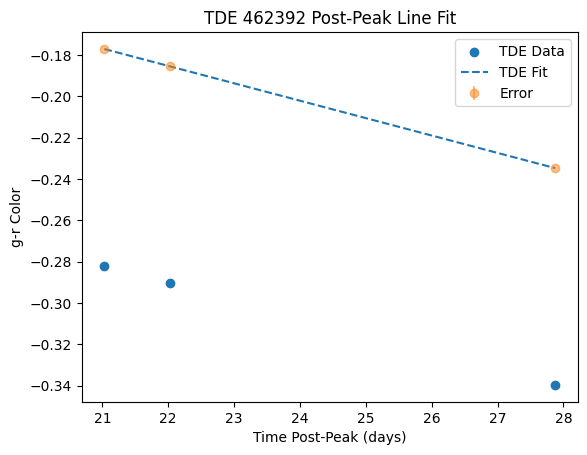

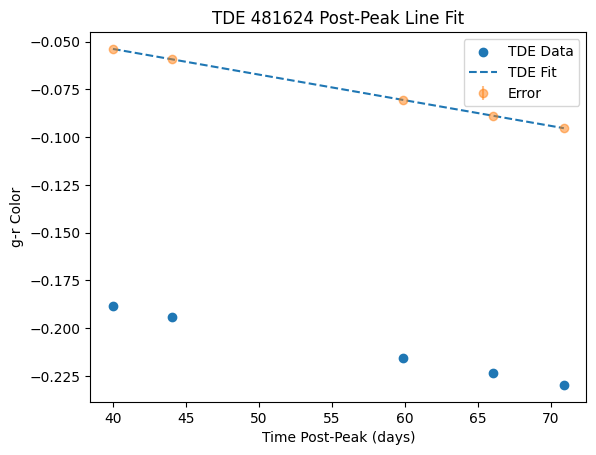

Skipping SNID 491498 due to error: the number of data points must exceed order to scale the covariance matrix


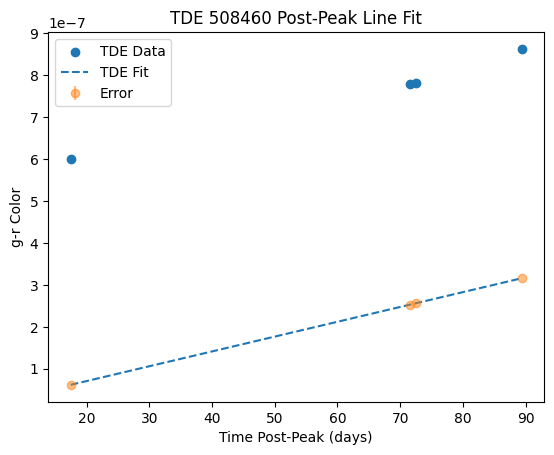

Debug: Skipping due to empty t.
Skipping SNID 596408 due to empty data.
Debug: Skipping due to empty t.
Skipping SNID 608780 due to empty data.
Debug: Skipping due to insufficient data points.
Skipping SNID 690476 due to empty data.
Debug: Skipping due to empty t.
Skipping SNID 753534 due to empty data.
Debug: Skipping due to insufficient data points.
Skipping SNID 795891 due to empty data.
Debug: Skipping due to insufficient data points.
Skipping SNID 845785 due to empty data.
Debug: Skipping due to empty t.
Skipping SNID 867217 due to empty data.
Skipping SNID 909850 due to error: the number of data points must exceed order to scale the covariance matrix
Debug: Skipping due to insufficient data points.
Skipping SNID 924578 due to empty data.
Debug: Skipping due to empty t.
Skipping SNID 1287303 due to empty data.
Debug: Skipping due to NaN values.
Skipping SNID 1287757 due to empty data.
Debug: Skipping due to empty t.
Skipping SNID 1318887 due to empty data.
Debug: Skipping due to e

 50%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 1/2 [13:20<13:20, 800.73s/it]

Skipping SNID 73990309 due to error: the number of data points must exceed order to scale the covariance matrix
Debug: Skipping due to empty t.
Skipping SNID 73991369 due to empty data.


/home/kunal/tdes-fzu/venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kunal/tdes-fzu/venv/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_200833/1690719555.py:8: RuntimeWarning: invalid value encountered in log10
  color = -2.5 * np.log10(flux_band1 / flux_band2)


Debug: Skipping due to NaN values.
Skipping SNID 7601 due to empty data.
Debug: Skipping due to empty t.
Skipping SNID 23511 due to empty data.
Debug: Skipping due to NaN values.
Skipping SNID 51385 due to empty data.
Debug: Skipping due to insufficient data points.
Skipping SNID 51620 due to empty data.
Debug: Skipping due to insufficient data points.
Skipping SNID 60346 due to empty data.
Debug: Skipping due to NaN values.
Skipping SNID 63006 due to empty data.
Debug: Skipping due to NaN values.
Skipping SNID 100452 due to empty data.
Debug: Skipping due to empty t.
Skipping SNID 107578 due to empty data.


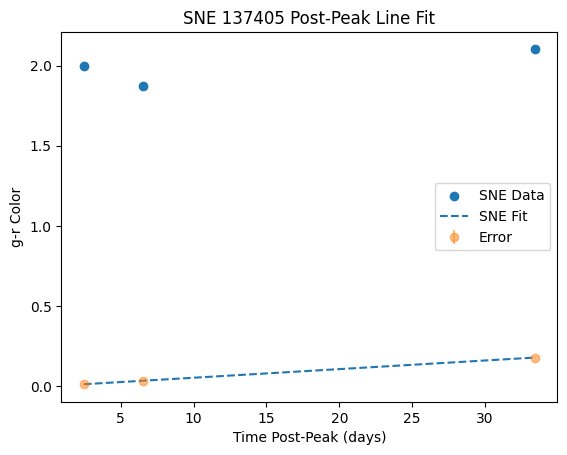

Debug: Skipping due to empty t.
Skipping SNID 174565 due to empty data.


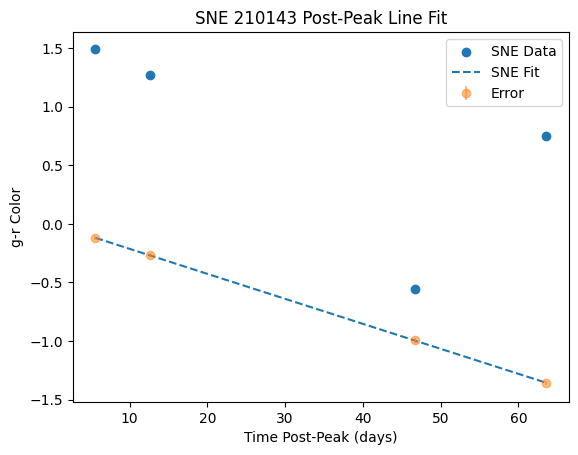

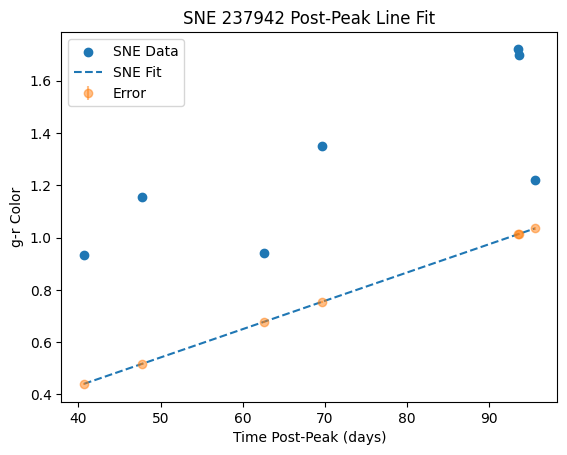

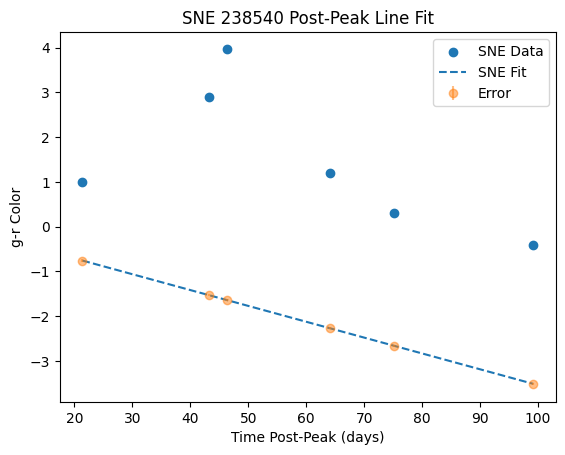

Debug: Skipping due to insufficient data points.
Skipping SNID 245785 due to empty data.


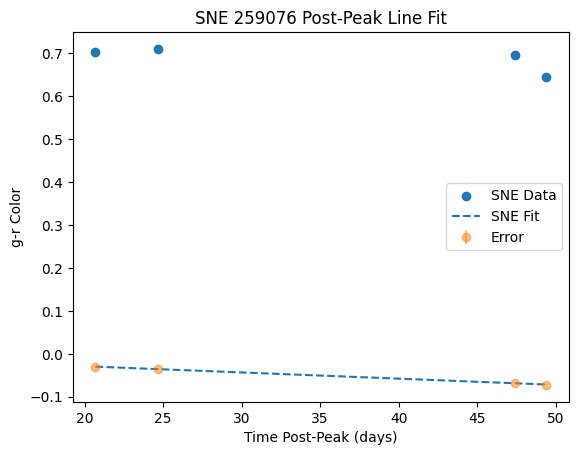

Debug: Skipping due to insufficient data points.
Skipping SNID 304108 due to empty data.


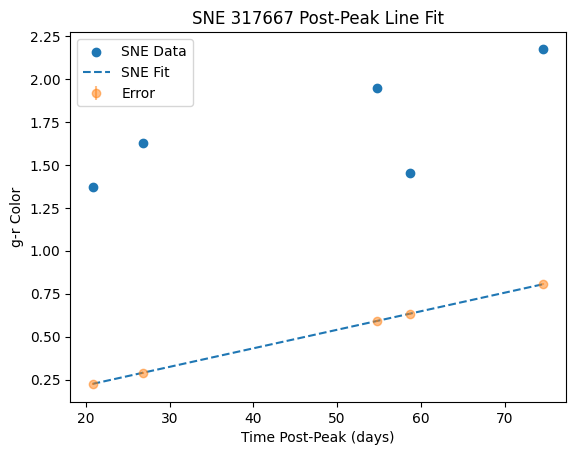

Debug: Skipping due to NaN values.
Skipping SNID 327417 due to empty data.
Skipping SNID 334789 due to error: the number of data points must exceed order to scale the covariance matrix
Debug: Skipping due to NaN values.
Skipping SNID 352951 due to empty data.


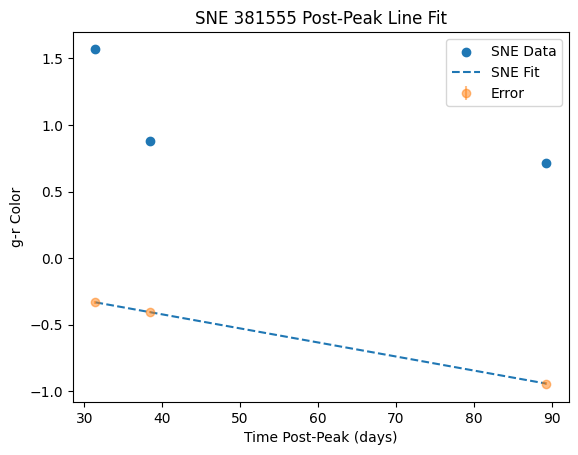

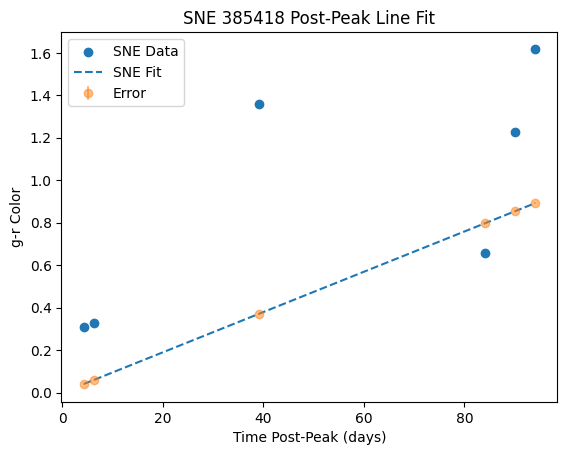

Debug: Skipping due to NaN values.
Skipping SNID 395562 due to empty data.


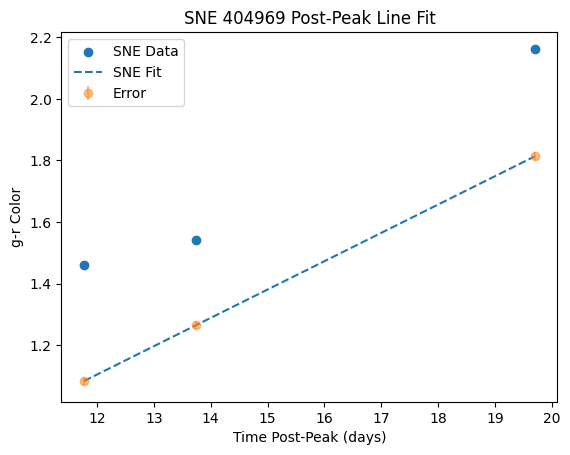

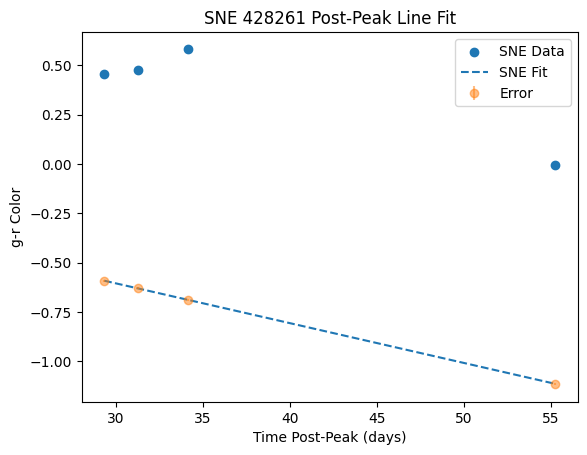

Debug: Skipping due to empty t.
Skipping SNID 428272 due to empty data.
Debug: Skipping due to empty t.
Skipping SNID 455670 due to empty data.
Debug: Skipping due to insufficient data points.
Skipping SNID 462566 due to empty data.
Debug: Skipping due to NaN values.
Skipping SNID 561629 due to empty data.
Debug: Skipping due to empty t.
Skipping SNID 566899 due to empty data.
Debug: Skipping due to insufficient data points.
Skipping SNID 569880 due to empty data.
Debug: Skipping due to empty t.
Skipping SNID 580063 due to empty data.
Debug: Skipping due to NaN values.
Skipping SNID 580381 due to empty data.
Skipping SNID 589631 due to error: the number of data points must exceed order to scale the covariance matrix
Debug: Skipping due to empty t.
Skipping SNID 615688 due to empty data.
Skipping SNID 647499 due to error: the number of data points must exceed order to scale the covariance matrix
Skipping SNID 688443 due to error: the number of data points must exceed order to scale the 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [38:04<00:00, 1142.20s/it]

Debug: Skipping due to NaN values.
Skipping SNID 74143398 due to empty data.


In [104]:
# Initialize counters
num_TDEs_plotted = 0
num_SNEs_plotted = 0

# Store plot data
plot_data_TDEs = []
plot_data_SNEs = []

for filename, object_type in tqdm(zip(all_filenames, object_types), total=len(all_filenames)):
    table, head = read_elasticc_file(filename)
    snids, shead_list, sub_list = get_snid_head_sub(table, head)

    color_slopes = []

    for snid, shead, sub in zip(snids, shead_list, sub_list):
        try:
            return_plot_data = False
            if (object_type == 'TDE' and num_TDEs_plotted < 10) or (object_type == 'SNE' and num_SNEs_plotted < 10):
                return_plot_data = True

            retvals = calc_mean_colors_and_slope(sub, shead, 'g', 'r', return_plot_data)

            if retvals is None:
                print(f"Skipping SNID {snid} due to empty data.")
                continue

            if return_plot_data:
                mean_color_pre_peak, mean_color_post_peak, color_slope, plot_data = retvals
                t, color, slope_std_err = plot_data  # unpack the plot_data tuple
                
                # Plot the data and fit line for this specific object
                plt.figure()
                plt.scatter(t, color, label=f'{object_type} Data')

                # Calculate predicted_color based on the slope
                predicted_color = color_slope * t  # No intercept here, assuming it's zero for simplicity
                plt.plot(t, predicted_color, label=f'{object_type} Fit', linestyle='--')
                
                # Plot error bars
                plt.errorbar(t, predicted_color, yerr=slope_std_err, fmt='o', label='Error', alpha=0.5)

                plt.xlabel('Time Post-Peak (days)')
                plt.ylabel('g-r Color')
                plt.legend()
                plt.title(f'{object_type} {snid} Post-Peak Line Fit')
                plt.show()

                if object_type == 'TDE':
                    num_TDEs_plotted += 1
                elif object_type == 'SNE':
                    num_SNEs_plotted += 1
            else:
                mean_color_pre_peak, mean_color_post_peak, color_slope = retvals

        except ValueError as e:
            print(f"Skipping SNID {snid} due to error: {e}")


## Rise and decay timescales

In [41]:

from scipy.optimize import minimize
from scipy.interpolate import interp1d



# Function for linear interpolation
def linear_interpolation_and_find_timescale(sub, shead):
    mask = sub['BAND'] == 'g'
    t = sub['MJD'][mask]  # Using MJD directly
    mag = sub['mag'][mask]

    mask = np.isfinite(mag)
    t, mag = t[mask], mag[mask]

    if len(t) < 2:
        print(f"Skipping SNID {shead['SNID']}: Insufficient data points.")
        return None, None

    f = interp1d(t, mag, kind='linear')
    fine_t = np.linspace(min(t), max(t), 1000)
    fine_mag = f(fine_t)

    peak_magnitude = np.min(fine_mag)
    peak_time = fine_t[np.argmin(fine_mag)]

    peak_MJD = shead['PEAKMJD']  # Value from the PEAKMJD column

    rise_time_candidate = fine_t[np.argmin(np.abs(fine_mag - (peak_magnitude + 1)))]
    decay_time_candidate = fine_t[np.argmin(np.abs(fine_mag - (peak_magnitude + 1)))]

    rise_time = peak_time - rise_time_candidate
    decay_time = decay_time_candidate - peak_time

    if rise_time < 0 or decay_time < 0:
        print(f"Skipping SNID {shead['SNID']}: Negative rise or decay time.")
        return None, None

    return rise_time, decay_time, peak_MJD



# Function for Gaussian Process
def compute_gp_and_find_timescale(sub, shead, linspace=100, GP_K=6000):
    t = sub['MJD'] - shead['PEAKMJD'] # Time since true peak
    flux, fluxerr = sub['FLUXCAL'], sub['FLUXCALERR'] # Flux 
    band = np.array([lsst_bands.get(_) for _ in sub['BAND']]) # Effective wavelengths
    
    x = np.vstack([t, band]).T # 2d positions of data points
    
    mask = np.isfinite(flux) & np.isfinite(fluxerr)
    flux, fluxerr = flux[mask], fluxerr[mask]
    
    kernel = 10*np.var(flux)*kernels.Matern32Kernel([linspace, GP_K**2], ndim=2)
    
    gp = george.GP(kernel)
    gp.compute(x, fluxerr)
    
    def neg_ln_like(p):
        gp.set_parameter_vector(p)
        return -gp.log_likelihood(flux)

    def grad_neg_ln_like(p):
        gp.set_parameter_vector(p)
        return -gp.grad_log_likelihood(flux)
        
    bounds = [(0, 10.0*np.log(np.var(flux))), (0, np.log(6000 ** 2)), (None, None)]
    result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like, bounds=bounds)
    
    gp.set_parameter_vector(result.x)
    
    fine_t = np.linspace(min(t), max(t), 1000)
    fine_x = np.vstack([fine_t, np.repeat(band.mean(), len(fine_t))]).T # Assuming band doesn't change
    mu, _ = gp.predict(flux, fine_x)
    
    peak_magnitude = np.min(mu)
    peak_time = fine_t[np.argmin(mu)]
    
    rise_time = peak_time - fine_t[np.argmin(np.abs(mu - (peak_magnitude + 1)))]
    decay_time = fine_t[np.argmin(np.abs(mu - (peak_magnitude + 1)))] - peak_time
    
    return rise_time, decay_time


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [04:45<00:00, 142.71s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Skipping SNID SNID
----
7601: Negative rise or decay time.
Skipping SNID  SNID
-----
23511: Negative rise or decay time.
Lengths: 14 14 14
First 10 object types: ['AGN', 'TDE', 'SNE', 'AGN', 'TDE', 'SNE', 'TDE', 'SNE', 'TDE', 'SNE']
For TDE, mask sum: 6
For SNE, mask sum: 6


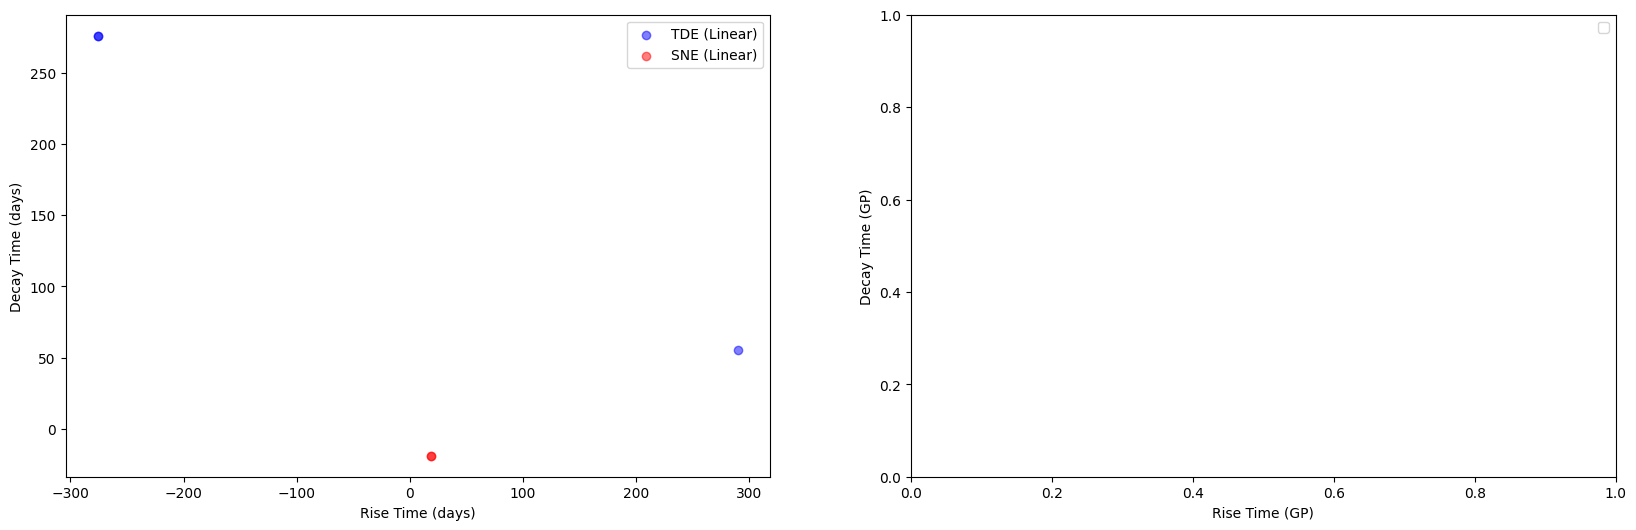

AttributeError: 'Column' object has no attribute 'time'

In [42]:

import time
start_time = time.time()


#agn_filenames = [f"/home/kunal/elasticc/fits/ELASTICC_TRAIN_AGN/ELASTICC_TRAIN_NONIaMODEL0-{str(i).zfill(4)}_HEAD.FITS.gz" for i in range(1, 2)]
tde_filenames = [f"/home/kunal/elasticc/fits/ELASTICC_TRAIN_TDE/ELASTICC_TRAIN_NONIaMODEL0-{str(i).zfill(4)}_HEAD.FITS.gz" for i in range(1, 2)]
sne_filenames = [f"/home/kunal/elasticc/fits/ELASTICC_TRAIN_SNIa-SALT2/ELASTICC_TRAIN_NONIaMODEL0-{str(i).zfill(4)}_HEAD.FITS.gz" for i in range(1, 2)]

all_filenames = tde_filenames + sne_filenames
object_types = ['TDE'] * len(tde_filenames) + ['SNE'] * len(sne_filenames)


for filename, object_type in tqdm(zip(all_filenames, object_types), total=len(all_filenames)):
    table, head = read_elasticc_file(filename)
    snids, shead_list, sub_list = get_snid_head_sub(table, head)
    
    
# Loop through the data
for snid, shead, sub, object_type in zip(snids, shead_list, sub_list, object_types):  
    time = sub['MJD']
    magnitude = sub['FLUXCAL']
    
    # Linear Interpolation
    rise_time_linear, decay_time_linear = linear_interpolation_and_find_timescale(sub, shead)
    all_rise_times_linear.append(rise_time_linear)
    all_decay_times_linear.append(decay_time_linear)
    
    # Gaussian Process
    #rise_time_gp, decay_time_gp = compute_gp_and_find_timescale(time, magnitude)
    #all_rise_times_gp.append(rise_time_gp)
    #all_decay_times_gp.append(decay_time_gp)

    # Object Types
    all_object_types.append(object_type)  # Append object type

        
# Debugging steps
print("Lengths:", len(all_rise_times_linear), len(all_decay_times_linear), len(all_object_types))
print("First 10 object types:", all_object_types[:10])

# Plotting
fig4, (ax6, ax7) = plt.subplots(1, 2, figsize=(20, 6))
colors = {'TDE': 'blue', 'SNE': 'red', 'AGN': 'green'}

for object_type in ['TDE', 'SNE']:
    mask = np.array(all_object_types) == object_type
    print(f"For {object_type}, mask sum: {np.sum(mask)}")  # Debugging line
    
    # Rise vs Decay using linear interpolation
    ax6.scatter(np.array(all_rise_times_linear)[mask], np.array(all_decay_times_linear)[mask], label=f"{object_type} (Linear)", alpha=0.5, color=colors[object_type])
    
    # Rise vs Decay using GP
    #ax7.scatter(np.array(all_rise_times_gp)[mask], np.array(all_decay_times_gp)[mask], label=f"{object_type} (GP)", alpha=0.5, color=colors[object_type], marker='x')

# Axis Labels and Legends
ax6.set_xlabel("Rise Time (days)")
ax6.set_ylabel("Decay Time (days)")
ax6.legend()

ax7.set_xlabel("Rise Time (GP)")
ax7.set_ylabel("Decay Time (GP)")
ax7.legend()
plt.show()

end_time = time.time()
print(f"Elapsed time: {end_time - start_time} seconds")

In [38]:
print(type(sub))
print(sub)
print(type(shead))
shead

<class 'astropy.table.table.Table'>
   MJD     BAND CCDNUM    FIELD     PHOTFLAG PHOTPROB   FLUXCAL   FLUXCALERR PSF_SIG1 PSF_SIG2 ... ZEROPT ZEROPT_ERR GAIN XPIX YPIX SIM_FLUXCAL_HOSTERR SIM_MAGOBS        mag               magerr        SNID
---------- ---- ------ ------------ -------- -------- ----------- ---------- -------- -------- ... ------ ---------- ---- ---- ---- ------------------- ---------- ------------------ ------------------ -----
60659.3558    z     -9 VOID                0     -9.0     20.4066  18.164518     1.66      0.0 ...  30.99      0.005  1.0 -9.0 -9.0                 0.0       99.0  24.22557258605957  0.966445803642273 23511
 60670.354    r     -9 VOID                0     -9.0  -1.2978842   5.689498     1.92      0.0 ...  31.58      0.005  1.0 -9.0 -9.0                 0.0       99.0                nan                nan 23511
60671.3565    r     -9 VOID                0     -9.0   -6.007717  5.8001614     1.85      0.0 ...  31.59      0.005  1.0 -9.0 -9.0     

SNID,IAUC,FAKE,RA,DEC,PIXSIZE,NXPIX,NYPIX,SNTYPE,NOBS,PTROBS_MIN,PTROBS_MAX,MWEBV,MWEBV_ERR,REDSHIFT_HELIO,REDSHIFT_HELIO_ERR,REDSHIFT_FINAL,REDSHIFT_FINAL_ERR,VPEC,VPEC_ERR,HOSTGAL_NMATCH,HOSTGAL_NMATCH2,HOSTGAL_OBJID,HOSTGAL_FLAG,HOSTGAL_PHOTOZ,HOSTGAL_PHOTOZ_ERR,HOSTGAL_SPECZ,HOSTGAL_SPECZ_ERR,HOSTGAL_RA,HOSTGAL_DEC,HOSTGAL_SNSEP,HOSTGAL_DDLR,HOSTGAL_CONFUSION,HOSTGAL_LOGMASS,HOSTGAL_LOGMASS_ERR,HOSTGAL_LOGSFR,HOSTGAL_LOGSFR_ERR,HOSTGAL_LOGsSFR,HOSTGAL_LOGsSFR_ERR,HOSTGAL_COLOR,HOSTGAL_COLOR_ERR,HOSTGAL_ELLIPTICITY,HOSTGAL_OBJID2,HOSTGAL_SQRADIUS,HOSTGAL_OBJID_UNIQUE,HOSTGAL_ZPHOT_Q000,HOSTGAL_ZPHOT_Q010,HOSTGAL_ZPHOT_Q020,HOSTGAL_ZPHOT_Q030,HOSTGAL_ZPHOT_Q040,HOSTGAL_ZPHOT_Q050,HOSTGAL_ZPHOT_Q060,HOSTGAL_ZPHOT_Q070,HOSTGAL_ZPHOT_Q080,HOSTGAL_ZPHOT_Q090,HOSTGAL_ZPHOT_Q100,HOSTGAL_MAG_u,HOSTGAL_MAG_g,HOSTGAL_MAG_r,HOSTGAL_MAG_i,HOSTGAL_MAG_z,HOSTGAL_MAG_Y,HOSTGAL_MAGERR_u,HOSTGAL_MAGERR_g,HOSTGAL_MAGERR_r,HOSTGAL_MAGERR_i,HOSTGAL_MAGERR_z,HOSTGAL_MAGERR_Y,HOSTGAL2_OBJID,HOSTGAL2_FLAG,HOSTGAL2_PHOTOZ,HOSTGAL2_PHOTOZ_ERR,HOSTGAL2_SPECZ,HOSTGAL2_SPECZ_ERR,HOSTGAL2_RA,HOSTGAL2_DEC,HOSTGAL2_SNSEP,HOSTGAL2_DDLR,HOSTGAL2_LOGMASS,HOSTGAL2_LOGMASS_ERR,HOSTGAL2_LOGSFR,HOSTGAL2_LOGSFR_ERR,HOSTGAL2_LOGsSFR,HOSTGAL2_LOGsSFR_ERR,HOSTGAL2_COLOR,HOSTGAL2_COLOR_ERR,HOSTGAL2_ELLIPTICITY,HOSTGAL2_OBJID2,HOSTGAL2_SQRADIUS,HOSTGAL2_OBJID_UNIQUE,HOSTGAL2_MAG_u,HOSTGAL2_MAG_g,HOSTGAL2_MAG_r,HOSTGAL2_MAG_i,HOSTGAL2_MAG_z,HOSTGAL2_MAG_Y,HOSTGAL2_MAGERR_u,HOSTGAL2_MAGERR_g,HOSTGAL2_MAGERR_r,HOSTGAL2_MAGERR_i,HOSTGAL2_MAGERR_z,HOSTGAL2_MAGERR_Y,HOSTGAL2_ZPHOT_Q000,HOSTGAL2_ZPHOT_Q010,HOSTGAL2_ZPHOT_Q020,HOSTGAL2_ZPHOT_Q030,HOSTGAL2_ZPHOT_Q040,HOSTGAL2_ZPHOT_Q050,HOSTGAL2_ZPHOT_Q060,HOSTGAL2_ZPHOT_Q070,HOSTGAL2_ZPHOT_Q080,HOSTGAL2_ZPHOT_Q090,HOSTGAL2_ZPHOT_Q100,HOSTGAL_SB_FLUXCAL_u,HOSTGAL_SB_FLUXCAL_g,HOSTGAL_SB_FLUXCAL_r,HOSTGAL_SB_FLUXCAL_i,HOSTGAL_SB_FLUXCAL_z,HOSTGAL_SB_FLUXCAL_Y,PEAKMJD,MJD_TRIGGER,MJD_DETECT_FIRST,MJD_DETECT_LAST,SEARCH_TYPE,SIM_MODEL_NAME,SIM_MODEL_INDEX,SIM_TYPE_INDEX,SIM_TYPE_NAME,SIM_TEMPLATE_INDEX,SIM_LIBID,SIM_NGEN_LIBID,SIM_NOBS_UNDEFINED,SIM_SEARCHEFF_MASK,SIM_REDSHIFT_HELIO,SIM_REDSHIFT_CMB,SIM_REDSHIFT_HOST,SIM_REDSHIFT_FLAG,SIM_VPEC,SIM_HOSTLIB_GALID,SIM_HOSTLIB(LOGMASS_TRUE),SIM_HOSTLIB(LOG_SFR),SIM_DLMU,SIM_LENSDMU,SIM_RA,SIM_DEC,SIM_MWEBV,SIM_PEAKMJD,SIM_MAGSMEAR_COH,SIM_AV,SIM_RV,SIM_SALT2x0,SIM_SALT2x1,SIM_SALT2c,SIM_SALT2mB,SIM_SALT2alpha,SIM_SALT2beta,SIM_SALT2gammaDM,SIM_PEAKMAG_u,SIM_PEAKMAG_g,SIM_PEAKMAG_r,SIM_PEAKMAG_i,SIM_PEAKMAG_z,SIM_PEAKMAG_Y,SIM_EXPOSURE_u,SIM_EXPOSURE_g,SIM_EXPOSURE_r,SIM_EXPOSURE_i,SIM_EXPOSURE_z,SIM_EXPOSURE_Y,SIM_GALFRAC_u,SIM_GALFRAC_g,SIM_GALFRAC_r,SIM_GALFRAC_i,SIM_GALFRAC_z,SIM_GALFRAC_Y,SIM_SUBSAMPLE_INDEX
int64,bytes16,int16,float64,float64,float32,int16,int16,int32,int32,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int64,int16,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,int16,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,bytes32,int16,int16,bytes8,int32,int32,int32,int32,int32,float32,float32,float32,int16,float32,int64,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,